<p style="text-align: center;">
    <span style="font-size: xx-large; font-weight: bold; color: red;">
        PROJET 7 :
        Implementez un modèle de scoring
    </span>
</p>  

__Sommaire__

**Partie 1 : Mise en place environnement  MLFlow**
- <a href="#C0">Import des bibliotheques</a>
- <a href="#C1">Environnement  MLFlow</a>

**Partie 2 : Exploration des données**
- <a href="#C2">Fonctions utiles</a>
- <a href="#C3">Chargement des fichiers</a>
- <a>Prétraitements des fichiers</a>
    - <a href="#C4"> Test et validation</a>
    - <a href="#C5"> bureau et bureau_balance</a>
    - <a href="#C6"> previous_application</a>
    - <a href="#C7"> posh_cash_balance</a>
    - <a href="#C8"> installments_payement</a>
    - <a href="#C9"> credit_card_balance</a>
- <a>Feature engineering (conservation des features qui ont moins de 80% de données manquantes)</a>
    - <a href="#C10"> df </a>
    - <a href="#C11"> bureau_agg</a>
    - <a href="#C12">previous_applications_agg </a>
    - <a href="#C13">installments_payments_agg </a>
    - <a href="#C14">credit_card_balance_agg</a>
    - <a href="#C15">home_credit </a>
- <a>Exploration variable cible</a>
    - <a href="#C16">feature target </a>

**Partie 3 : Préparation des données**   



# <span style="color:green; font-weight:bold;">Partie 1 : Mise en place environnement  MLFlow</span>

# <a name="C0"><span style="text-decoration: underline;">Import des bibliothèques</span></a>

In [321]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#pip install mlflow
#pip install dask

In [322]:
import os
import sys

print("Python version:", sys.version)
print("Python executable:", sys.executable)
print("Current working directory:", os.getcwd())

Python version: 3.11.7 (main, Dec 15 2023, 12:09:04) [Clang 14.0.6 ]
Python executable: /opt/anaconda3/bin/python
Current working directory: /Users/Nelly/Desktop/projet7


# <a name="C1"><span style="text-decoration: underline;">Environnement  MLFlow</span></a>

In [324]:
# Configuration du serveur de suivi MLflow (ici en local)
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Spécifiez une expérience MLflow
mlflow.set_experiment("Credit Scoring Model")

#lancer dans le terminal pour visualiser : mlflow ui

<Experiment: artifact_location='mlflow-artifacts:/136911579434586320', creation_time=1730232896148, experiment_id='136911579434586320', last_update_time=1730232896148, lifecycle_stage='active', name='Credit Scoring Model', tags={}>

# <span style="color:green; font-weight:bold;">Partie 2 : Analyse exploratoire des données</span>

# <a name="C2"><span style="text-decoration: underline;">Fonctions utiles</span></a>

In [327]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [328]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# <a name="C3"><span style="text-decoration: underline;">Chargement des fichiers</span></a>

In [330]:
# Charger les fichiers en utilisant dask
sample_submission = pd.read_csv("/Users/Nelly/Desktop/projet 7/data/sample_submission.csv")
home_credit = pd.read_csv("/Users/Nelly/Desktop/projet 7/data/HomeCredit_columns_description.csv", encoding="ISO-8859-1")

# <a name="C4"><span style="text-decoration: underline;">Prétraitement des fichiers de validation et d'entrainement</span></a>

In [332]:
# Prétraitement des fichiers application_train.csv et application_test.csv sans limitation de lignes
def application_train_test(nan_as_category=False):
    # Lire les données complètes et fusionner
    df = pd.read_csv("/Users/Nelly/Desktop/projet 7/data/application_train.csv")
    test_df = pd.read_csv("/Users/Nelly/Desktop/projet 7/data/application_test.csv")
    print("Échantillons d'entraînement : {}, échantillons de test : {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index(drop=True)
    
    # Optionnel : Supprimer les applications avec CODE_GENDER 'XNA' (ensemble d'entraînement)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Caractéristiques catégorielles avec encodage binaire (0 ou 1 ; deux catégories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
        
    # Caractéristiques catégorielles avec encodage One-Hot
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # Valeurs NaN pour DAYS_EMPLOYED : 365.243 -> NaN
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    
    # Quelques nouvelles caractéristiques simples (pourcentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    del test_df
    gc.collect()
    return df

In [333]:
# Appel de la fonction pour voir le résultat
df = application_train_test(nan_as_category=True)
df.head()

Échantillons d'entraînement : 307511, échantillons de test : 48744


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,0,0,1,0,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,1,0,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,0,1,0,0,1,0.011814,0.500000,67500.0,0.100000,0.050000
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0,1,0,0,1,0.159905,0.431748,67500.0,0.219900,0.094941
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,0,1,0,0,1,0.152418,0.236842,121500.0,0.179963,0.042623


In [334]:
print('Training/test data shape: ', df.shape)

Training/test data shape:  (356251, 260)


In [335]:
# Missing values statistics
missing_values = missing_values_table(df)
missing_values.head(20)

Your selected dataframe has 260 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_AVG,248357,69.7
COMMONAREA_MEDI,248357,69.7
COMMONAREA_MODE,248357,69.7
NONLIVINGAPARTMENTS_MODE,246859,69.3
NONLIVINGAPARTMENTS_MEDI,246859,69.3
NONLIVINGAPARTMENTS_AVG,246859,69.3
LIVINGAPARTMENTS_MODE,242977,68.2
LIVINGAPARTMENTS_AVG,242977,68.2
LIVINGAPARTMENTS_MEDI,242977,68.2
FLOORSMIN_AVG,241106,67.7


Dans des travaux ultérieurs, nous utiliserons des modèles tels que XGBoost qui peuvent gérer les valeurs manquantes sans avoir besoin d’imputation.

In [337]:
# nombre des differents types
df.dtypes.value_counts()

uint8      146
float64     72
int64       42
dtype: int64

# <a name="C5"><span style="text-decoration: underline;">Prétraitement des données bureau et bureau_balance</span></a>

In [339]:
# Prétraitement des fichiers bureau.csv et bureau_balance.csv
def bureau_and_balance(num_rows=None, nan_as_category=True):
    bureau = pd.read_csv("/Users/Nelly/Desktop/projet 7/data/bureau.csv")
    bb = pd.read_csv("/Users/Nelly/Desktop/projet 7/data/bureau_balance.csv")
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance : Effectuer des agrégations et fusionner avec bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect()
    
    # Caractéristiques numériques de bureau et bureau_balance
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Caractéristiques catégorielles de bureau et bureau_balance
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau : Crédits actifs - en utilisant uniquement les agrégations numériques
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau : Crédits clôturés - en utilisant uniquement les agrégations numériques
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [340]:
# Charger et afficher le DataFrame résultant
bureau_agg = bureau_and_balance()

In [341]:
bureau_agg.head() 

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,...,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,240043.666667,-1329.0,1778.0,82.428571,-93.142857,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-51.0,0.0,35.0,140.0
100002,-1437,-103,-874.000000,186150.000000,-1072.0,780.0,-349.000000,-499.875000,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-47.0,0.0,15.0,90.0
100003,-2586,-606,-1400.750000,827783.583333,-2434.0,1216.0,-544.500000,-816.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100004,-1326,-408,-867.000000,421362.000000,-595.0,-382.0,-488.500000,-532.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100005,-373,-62,-190.666667,26340.333333,-128.0,1324.0,439.333333,-54.333333,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-12.0,0.0,13.0,13.0


In [342]:
print('bureau/bureau_balance : ', bureau_agg.shape)

bureau/bureau_balance :  (305811, 116)


In [343]:
# Missing values statistics
missing_values = missing_values_table(bureau_agg)
missing_values.head()

Your selected dataframe has 116 columns.
There are 78 columns that have missing values.


,Missing Values,% of Total Values
ACTIVE_AMT_ANNUITY_MEAN,213085,69.7
ACTIVE_AMT_ANNUITY_MAX,213085,69.7
CLOSED_AMT_ANNUITY_MEAN,210614,68.9
CLOSED_AMT_ANNUITY_MAX,210614,68.9
ACTIVE_MONTHS_BALANCE_MIN_MIN,194662,63.7


# <a name="C5"><span style="text-decoration: underline;">Prétraitement des données de previous_application</span></a>

In [345]:
# Fonction pour l'encodage One-Hot
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    df = pd.get_dummies(df, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Prétraitement de previous_applications.csv
def previous_applications(nan_as_category=True):
    prev = pd.read_csv("/Users/Nelly/Desktop/projet 7/data/previous_application.csv")
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)
    
    # Valeurs de 365.243 jours -> NaN
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
    
    # Ajouter une caractéristique : pourcentage de la valeur demandée / valeur reçue
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    
    # Caractéristiques numériques des demandes précédentes
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Caractéristiques catégorielles des demandes précédentes
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Demandes précédentes : Demandes approuvées - uniquement les caractéristiques numériques
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Demandes précédentes : Demandes refusées - uniquement les caractéristiques numériques
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [346]:
# Exécuter la fonction et afficher le DataFrame
previous_applications_agg = previous_applications()

In [347]:
previous_applications_agg.head()

,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_APP_CREDIT_PERC_MIN,...,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_RATE_DOWN_PAYMENT_MIN,REFUSED_RATE_DOWN_PAYMENT_MAX,REFUSED_RATE_DOWN_PAYMENT_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_MEAN,REFUSED_CNT_PAYMENT_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3951.000,3951.000,3951.000,24835.5,24835.5,24835.50,23787.0,23787.0,23787.00,1.044079,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100002,9251.775,9251.775,9251.775,179055.0,179055.0,179055.00,179055.0,179055.0,179055.00,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,6737.310,98356.995,56553.990,68809.5,900000.0,435436.50,68053.5,1035882.0,484191.00,0.868825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,5357.250,5357.250,5357.250,24282.0,24282.0,24282.00,20106.0,20106.0,20106.00,1.207699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,4813.200,4813.200,4813.200,0.0,44617.5,22308.75,0.0,40153.5,20076.75,1.111173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [348]:
print('previous : ', previous_applications_agg.shape)

previous :  (338857, 249)


In [349]:
# Missing values statistics
missing_values = missing_values_table(previous_applications_agg)
missing_values.head()

Your selected dataframe has 249 columns.
There are 77 columns that have missing values.


,Missing Values,% of Total Values
REFUSED_RATE_DOWN_PAYMENT_MAX,286252,84.5
REFUSED_RATE_DOWN_PAYMENT_MIN,286252,84.5
REFUSED_AMT_DOWN_PAYMENT_MEAN,286252,84.5
REFUSED_AMT_DOWN_PAYMENT_MAX,286252,84.5
REFUSED_AMT_DOWN_PAYMENT_MIN,286252,84.5


# <a name="C6"><span style="text-decoration: underline;">Prétraitement des données de POS_CASH_balance</span></a>

In [351]:
# Prétraitement de POS_CASH_balance.csv
def pos_cash(num_rows=None, nan_as_category=True):
    pos = pd.read_csv("/Users/Nelly/Desktop/projet 7/data/POS_CASH_balance.csv")
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    
    # Caractéristiques
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    # Compter le nombre de comptes POS cash
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [352]:
# Charger et visualiser le DataFrame
pos_cash_agg = pos_cash()

In [353]:
pos_cash_agg.head()

,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_NAME_CONTRACT_STATUS_nan_MEAN,POS_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,
100001,-53,-72.555556,9,7,0.777778,7,0.777778,0.777778,0.0,0.0,0.0,0.222222,0.0,0.0,0.000000,0.0,0.0,9
100002,-1,-10.000000,19,0,0.000000,0,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,19
100003,-18,-43.785714,28,0,0.000000,0,0.000000,0.928571,0.0,0.0,0.0,0.071429,0.0,0.0,0.000000,0.0,0.0,28
100004,-24,-25.500000,4,0,0.000000,0,0.000000,0.750000,0.0,0.0,0.0,0.250000,0.0,0.0,0.000000,0.0,0.0,4
100005,-15,-20.000000,11,0,0.000000,0,0.000000,0.818182,0.0,0.0,0.0,0.090909,0.0,0.0,0.090909,0.0,0.0,11


In [354]:
print('pos_cash : ', pos_cash_agg.shape)

pos_cash :  (337252, 18)


In [355]:
# Missing values statistics
missing_values = missing_values_table(pos_cash_agg)
missing_values.head()

Your selected dataframe has 18 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


# <a name="C7"><span style="text-decoration: underline;">Prétraitement des données installments_payments</span></a>

In [357]:
# Fonction pour l'encodage One-Hot
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    df = pd.get_dummies(df, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Prétraitement de installments_payments.csv
def installments_payments(nan_as_category=True):
    # Lire les données de installments_payments
    ins = pd.read_csv("/Users/Nelly/Desktop/projet 7/data/installments_payments.csv")
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
    
    # Pourcentage et différence payés dans chaque versement (montant payé et valeur du versement)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    
    # Jours de retard et jours avant échéance (pas de valeurs négatives)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # Caractéristiques : effectuer des agrégations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    
    # Compter le nombre de comptes de versements
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    
    # Libérer la mémoire
    del ins
    gc.collect()
    
    return ins_agg

In [358]:
# Charger et visualiser le DataFrame
installments_payments_agg = installments_payments()

In [359]:
installments_payments_agg.head()

,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,2,11.0,1.571429,11.0,36.0,8.857143,62.0,1.0,1.0,7.0,...,5885.132143,41195.925,3951.000,17397.900,5885.132143,41195.925,-1628.0,-2195.000000,-15365.0,7
100002,2,0.0,0.000000,0.0,31.0,20.421053,388.0,1.0,1.0,19.0,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19
100003,2,0.0,0.000000,0.0,14.0,7.160000,179.0,1.0,1.0,25.0,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25
100004,2,0.0,0.000000,0.0,11.0,7.666667,23.0,1.0,1.0,3.0,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3
100005,2,1.0,0.111111,1.0,37.0,23.666667,213.0,1.0,1.0,9.0,...,6240.205000,56161.845,4813.200,17656.245,6240.205000,56161.845,-470.0,-609.555556,-5486.0,9


In [360]:
print('installments payments : ', installments_payments_agg.shape)

installments payments :  (339587, 26)


In [361]:
# Missing values statistics
missing_values = missing_values_table(installments_payments_agg)
missing_values.head()

Your selected dataframe has 26 columns.
There are 12 columns that have missing values.


,Missing Values,% of Total Values
INSTAL_PAYMENT_PERC_VAR,996,0.3
INSTAL_PAYMENT_DIFF_VAR,977,0.3
INSTAL_PAYMENT_PERC_MEAN,28,0.0
INSTAL_PAYMENT_PERC_SUM,19,0.0
INSTAL_PAYMENT_PERC_MAX,9,0.0


# <a name="C7"><span style="text-decoration: underline;">Prétraitement des données credit_card_balance</span></a>

In [363]:
# Prétraitement de credit_card_balance.csv
def credit_card_balance(nan_as_category=True):
    cc = pd.read_csv("/Users/Nelly/Desktop/projet 7/data/credit_card_balance.csv")
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)
    
    # Agrégations générales
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    # Compter le nombre de lignes de carte de crédit
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    
    del cc
    gc.collect()
    return cc_agg

In [364]:
# Charger et visualiser le DataFrame
credit_card_balance_agg = credit_card_balance()
credit_card_balance_agg.head()

,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_VAR,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-6,-1,-3.5,-21,3.5,0.0,0.00,0.000000,0.000,0.000000e+00,...,0,0.0,0,0.0,0,0,0.0,0,0.0,6
100011,-75,-2,-38.5,-2849,462.5,0.0,189000.00,54482.111149,4031676.225,4.641321e+09,...,0,0.0,0,0.0,0,0,0.0,0,0.0,74
100013,-96,-1,-48.5,-4656,776.0,0.0,161420.22,18159.919219,1743352.245,1.869473e+09,...,0,0.0,0,0.0,0,0,0.0,0,0.0,96
100021,-18,-2,-10.0,-170,25.5,0.0,0.00,0.000000,0.000,0.000000e+00,...,0,0.0,0,0.0,0,0,0.0,0,0.0,17
100023,-11,-4,-7.5,-60,6.0,0.0,0.00,0.000000,0.000,0.000000e+00,...,0,0.0,0,0.0,0,0,0.0,0,0.0,8


In [365]:
print('credit_card_balance_agg : ', credit_card_balance_agg.shape)

credit_card_balance_agg :  (103558, 141)


In [366]:
# Missing values statistics
missing_values = missing_values_table(credit_card_balance_agg)
missing_values.head()

Your selected dataframe has 141 columns.
There are 49 columns that have missing values.


,Missing Values,% of Total Values
CC_AMT_PAYMENT_CURRENT_VAR,31956,30.9
CC_CNT_DRAWINGS_POS_CURRENT_VAR,31866,30.8
CC_AMT_DRAWINGS_OTHER_CURRENT_VAR,31866,30.8
CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,31866,30.8
CC_CNT_DRAWINGS_ATM_CURRENT_VAR,31866,30.8


**sample_submission**

In [368]:
print('sample_submission : ', sample_submission.shape)

sample_submission :  (48744, 2)


In [369]:
# Missing values statistics
missing_values = missing_values_table(sample_submission)
missing_values.head()

Your selected dataframe has 2 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


**HomeCredit_columns_description**

In [371]:
print('home_credit : ', home_credit.shape)

home_credit :  (219, 5)


In [372]:
# Missing values statistics
missing_values = missing_values_table(home_credit)
missing_values.head()

Your selected dataframe has 5 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
Special,133,60.7


# <a name="C2"><span style="text-decoration: underline;">Traitement données manquantes df</span></a>

les data frames qui ont des données manquantes : 
- df
- bureau_agg
- previous_applications_agg
- installments_payments_agg
- credit_card_balance_agg
- home_credit

In [375]:
# Calculer les statistiques des valeurs manquantes
missing_values = missing_values_table(df)

# Filtrer pour obtenir uniquement les caractéristiques avec plus de 80 % de valeurs manquantes
missing_values_80 = missing_values[missing_values['% of Total Values'] > 80]

# Afficher les premières lignes des colonnes avec plus de 80 % de valeurs manquantes
print(missing_values_80)

Your selected dataframe has 260 columns.
There are 67 columns that have missing values.
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


# <a name="C2"><span style="text-decoration: underline;">Traitement données manquantes bureau_agg</span></a>

In [377]:
# Calculer les statistiques des valeurs manquantes
missing_values = missing_values_table(bureau_agg)

# Filtrer pour obtenir uniquement les caractéristiques avec plus de 80 % de valeurs manquantes
missing_values_80 = missing_values[missing_values['% of Total Values'] > 80]

# Afficher les premières lignes des colonnes avec plus de 80 % de valeurs manquantes
print(missing_values_80)

Your selected dataframe has 116 columns.
There are 78 columns that have missing values.
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


# <a name="C2"><span style="text-decoration: underline;">Traitement données manquantes previous_applications_agg</span></a>

In [379]:
# Calculer les statistiques des valeurs manquantes
missing_values = missing_values_table(previous_applications_agg)

# Filtrer pour obtenir les caractéristiques avec plus de 80 % de valeurs manquantes
features_to_drop = missing_values[missing_values['% of Total Values'] > 80].index

# Supprimer les colonnes avec plus de 80 % de valeurs manquantes du DataFrame principal
previous_applications_agg_cleaned = previous_applications_agg.drop(columns=features_to_drop)

# Afficher la forme du DataFrame après la suppression
print("DataFrame initial :", previous_applications_agg.shape)
print("DataFrame après suppression des colonnes avec plus de 80 % de valeurs manquantes :", previous_applications_agg_cleaned.shape)

Your selected dataframe has 249 columns.
There are 77 columns that have missing values.
DataFrame initial : (338857, 249)
DataFrame après suppression des colonnes avec plus de 80 % de valeurs manquantes : (338857, 242)


# <a name="C2"><span style="text-decoration: underline;">Traitement données manquantes installments_payments_agg</span></a>

In [381]:
# Calculer les statistiques des valeurs manquantes
missing_values = missing_values_table(installments_payments_agg)

# Filtrer pour obtenir uniquement les caractéristiques avec plus de 80 % de valeurs manquantes
missing_values_80 = missing_values[missing_values['% of Total Values'] > 80]

# Afficher les premières lignes des colonnes avec plus de 80 % de valeurs manquantes
print(missing_values_80)

Your selected dataframe has 26 columns.
There are 12 columns that have missing values.
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


# <a name="C2"><span style="text-decoration: underline;">Traitement données manquantes credit_card_balance_agg</span></a>

In [383]:
# Calculer les statistiques des valeurs manquantes
missing_values = missing_values_table(credit_card_balance_agg)

# Filtrer pour obtenir uniquement les caractéristiques avec plus de 80 % de valeurs manquantes
missing_values_80 = missing_values[missing_values['% of Total Values'] > 80]

# Afficher les premières lignes des colonnes avec plus de 80 % de valeurs manquantes
print(missing_values_80)

Your selected dataframe has 141 columns.
There are 49 columns that have missing values.
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


# <a name="C2"><span style="text-decoration: underline;">Traitement données manquantes home_credit</span></a>

In [385]:
# Calculer les statistiques des valeurs manquantes
missing_values = missing_values_table(home_credit)

# Filtrer pour obtenir uniquement les caractéristiques avec plus de 80 % de valeurs manquantes
missing_values_80 = missing_values[missing_values['% of Total Values'] > 80]

# Afficher les premières lignes des colonnes avec plus de 80 % de valeurs manquantes
print(missing_values_80)

Your selected dataframe has 5 columns.
There are 1 columns that have missing values.
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


# <a name="C2"><span style="text-decoration: underline;">Exploration variable cible (target)</span></a>

In [387]:
df['TARGET'].value_counts()

0.0    282682
1.0     24825
Name: TARGET, dtype: int64

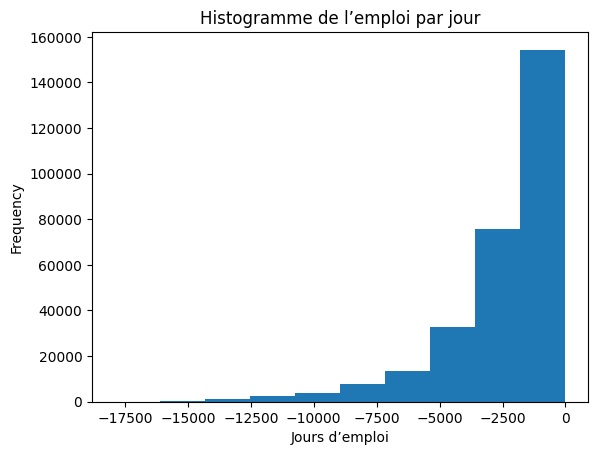

In [388]:
# Create an anomalous flag column
df['DAYS_EMPLOYED_ANOM'] = df["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

df['DAYS_EMPLOYED'].plot.hist(title = 'Histogramme de l’emploi par jour');
plt.xlabel('Jours d’emploi');

In [389]:
# Trouver les corrélations avec la cible et trier
correlations = df.corr()['TARGET'].sort_values()

# Afficher les corrélations
print('Corrélations les plus positives :\n', correlations.tail(15))
print('\nCorrélations les plus négatives :\n', correlations.head(15))

Corrélations les plus positives :
 DAYS_LAST_PHONE_CHANGE            0.055219
NAME_INCOME_TYPE_Working          0.057483
REGION_RATING_CLIENT              0.058901
REGION_RATING_CLIENT_W_CITY       0.060895
DAYS_EMPLOYED                     0.074957
DAYS_BIRTH                        0.078242
TARGET                            1.000000
NAME_CONTRACT_TYPE_nan                 NaN
NAME_INCOME_TYPE_nan                   NaN
NAME_EDUCATION_TYPE_nan                NaN
NAME_FAMILY_STATUS_nan                 NaN
NAME_HOUSING_TYPE_nan                  NaN
WEEKDAY_APPR_PROCESS_START_nan         NaN
ORGANIZATION_TYPE_nan                  NaN
DAYS_EMPLOYED_ANOM                     NaN
Name: TARGET, dtype: float64

Corrélations les plus négatives :
 EXT_SOURCE_3                           -0.178926
EXT_SOURCE_2                           -0.160471
EXT_SOURCE_1                           -0.155317
DAYS_EMPLOYED_PERC                     -0.067952
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDE

In [390]:
# Informations d'âge dans un DataFrame séparé
age_data = df[['TARGET', 'DAYS_BIRTH']]

# Prendre la valeur absolue de DAYS_BIRTH pour enlever les valeurs négatives, puis convertir en années
age_data['DAYS_BIRTH'] = age_data['DAYS_BIRTH'].abs()  # Cette ligne prend la valeur absolue
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Créer des intervalles d'âge personnalisés de 5 en 5 ans
bins = [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins=bins)

# Afficher les premières lignes
print(age_data.head(10))

   TARGET  DAYS_BIRTH  YEARS_BIRTH YEARS_BINNED
0     1.0        9461    25.920548     (25, 30]
1     0.0       16765    45.931507     (45, 50]
2     0.0       19046    52.180822     (50, 55]
3     0.0       19005    52.068493     (50, 55]
4     0.0       19932    54.608219     (50, 55]
5     0.0       16941    46.413699     (45, 50]
6     0.0       13778    37.747945     (35, 40]
7     0.0       18850    51.643836     (50, 55]
8     0.0       20099    55.065753     (55, 60]
9     0.0       14469    39.641096     (35, 40]


In [391]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20, 25]",0.123036,8538.378305,23.392817
"(25, 30]",0.111442,10158.553997,27.831655
"(30, 35]",0.102814,11856.378412,32.483229
"(35, 40]",0.089416,13708.090454,37.556412
"(40, 45]",0.078491,15497.596332,42.459168
"(45, 50]",0.074171,17323.579317,47.461861
"(50, 55]",0.066968,19193.920120,52.586083
"(55, 60]",0.055316,20982.126230,57.485277
"(60, 65]",0.052737,22779.717434,62.410185


Text(0.5, 1.0, "Défaut de remboursement par groupe d'âge")

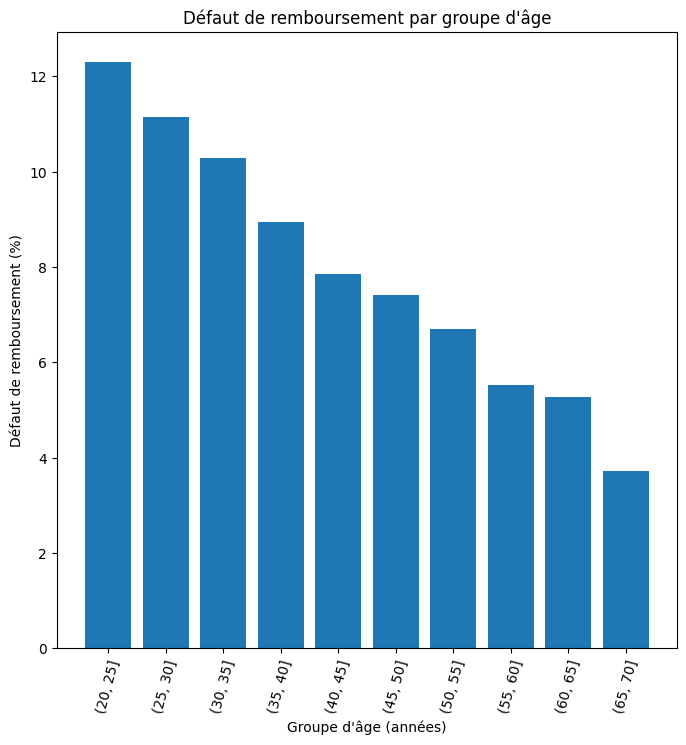

In [392]:
plt.figure(figsize = (8, 8))

# Graphique des tranches d'âge et de la moyenne de la cible sous forme de diagramme à barres
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Étiquettes du graphique
plt.xticks(rotation = 75)
plt.xlabel('Groupe d\'âge (années)')
plt.ylabel('Défaut de remboursement (%)')
plt.title('Défaut de remboursement par groupe d\'âge')

Il y a une tendance claire : les jeunes demandeurs sont plus susceptibles de ne pas rembourser le prêt! Le taux de non-remboursement est supérieur à 10 % pour les trois groupes d’âge les plus jeunes et inférieur à 5 % pour le groupe d’âge le plus âgé.

# <span style="color:green; font-weight:bold;">Partie 3 : Préparation des données pour la modélisation</span>

In [395]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import ADASYN

# <a name="C2"><span style="text-decoration: underline;">Prétraitement des données</span></a>

In [397]:
import pandas as pd
from imblearn.over_sampling import ADASYN
from sklearn.utils import resample
from collections import Counter

# Charger le fichier CSV
df = pd.read_csv("/Users/Nelly/Desktop/projet 7/data/application_train.csv")

# Fonction d'encodage one-hot
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Appliquer l'encodage one-hot
df, new_columns = one_hot_encoder(df, nan_as_category=True)

# Vérifier les colonnes disponibles
print("Colonnes disponibles :", df.columns)

Colonnes disponibles : Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       ...
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
       'WALLSMATERIAL_MODE_nan', 'EMERGENCYSTATE_MODE_No',
       'EMERGENCYSTATE_MODE_Yes', 'EMERGENCYSTATE_MODE_nan'],
      dtype='object', length=262)


# <a name="C2"><span style="text-decoration: underline;">Traitement données train avec/sans réequilibrage</span></a>

In [399]:
# Étape 1 : DataFrame sans rééquilibrage
df_no_balancing = df.copy()

# Vérifier les proportions dans le jeu déséquilibré
print("Proportions sans rééquilibrage :")
print(df_no_balancing['TARGET'].value_counts())

Proportions sans rééquilibrage :
0    282686
1     24825
Name: TARGET, dtype: int64


In [400]:
# Préparer les données pour ADASYN
X = df.drop(columns=['TARGET'])  # Features
y = df['TARGET']  # Cible

# Vérifier les valeurs manquantes
print("Nombre de valeurs manquantes avant imputation :", X.isnull().sum().sum())

# Imputer les valeurs manquantes
X = X.fillna(0)

# Vérifier les proportions actuelles
print("Proportions avant rééquilibrage :", Counter(y))

Nombre de valeurs manquantes avant imputation : 8388094
Proportions avant rééquilibrage : Counter({0: 282686, 1: 24825})


In [401]:
# Calculer le nombre exact d'échantillons pour équilibrer
count_majority = y.value_counts()[0]  # Nombre dans la classe majoritaire
count_minority = y.value_counts()[1]  # Nombre dans la classe minoritaire
samples_needed = count_majority - count_minority  # Nombre d'échantillons nécessaires pour équilibrer

print(f"Classe majoritaire : {count_majority}")
print(f"Classe minoritaire : {count_minority}")
print(f"Échantillons nécessaires pour équilibrer : {samples_needed}")

# Rééquilibrer les données avec ADASYN
adasyn = ADASYN(sampling_strategy={1: count_majority}, random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

Classe majoritaire : 282686
Classe minoritaire : 24825
Échantillons nécessaires pour équilibrer : 257861


In [402]:
# Créer le DataFrame rééquilibré après ADASYN
df_with_balancing = pd.DataFrame(X_resampled, columns=X.columns)
df_with_balancing['TARGET'] = y_resampled

# Séparer les classes majoritaire et minoritaire
df_majority = df_with_balancing[df_with_balancing['TARGET'] == 0]
df_minority = df_with_balancing[df_with_balancing['TARGET'] == 1]

# Sous-échantillonnage de la classe minoritaire
df_minority_balanced = resample(df_minority, 
                                replace=False,  # Pas de duplication
                                n_samples=len(df_majority),  # Taille cible = classe majoritaire
                                random_state=42)

# Fusionner les deux classes pour obtenir un DataFrame équilibré
df_balanced = pd.concat([df_majority, df_minority_balanced])

# Vérifier les proportions finales
print("Proportions finales après ajustement exact :")
print(df_balanced['TARGET'].value_counts())

/var/folders/q2/f633dk6n45gd7gqw115zydhw0000gn/T/ipykernel_1240/251193402.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Proportions finales après ajustement exact :
0    282686
1    282686
Name: TARGET, dtype: int64


In [403]:
# Sauvegarde ou utilisation des deux DataFrames
df_no_balancing.to_csv("/Users/Nelly/Desktop/projet 7/data/dataset_sans_reequilibrage.csv", index=False)
df_balanced.to_csv("/Users/Nelly/Desktop/projet 7/data/dataset_avec_reequilibrage.csv", index=False)

print("Les fichiers ont été sauvegardés avec succès.")

Les fichiers ont été sauvegardés avec succès.


# <a name="C2"><span style="text-decoration: underline;">Modélisation</span></a>

In [405]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [406]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix

In [407]:
# Charger les deux fichiers
df_no_balancing = pd.read_csv("/Users/Nelly/Desktop/projet 7/data/dataset_sans_reequilibrage.csv")
df_balanced = pd.read_csv("/Users/Nelly/Desktop/projet 7/data/dataset_avec_reequilibrage.csv")

# Préparer les features (X) et la cible (y)
def prepare_data(df):
    X = df.drop(columns=['TARGET'])
    y = df['TARGET']
    return X, y

X_no_balancing, y_no_balancing = prepare_data(df_no_balancing)
X_balanced, y_balanced = prepare_data(df_balanced)

# Diviser les jeux de données en entraînement et test
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(X_no_balancing, y_no_balancing, test_size=0.3, random_state=42, stratify=y_no_balancing)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

In [408]:
# Calcul des valeurs manquantes pour chaque dataset
missing_no = X_no_balancing.isnull().sum()  # Somme des valeurs manquantes par colonne
missing_bal = X_balanced.isnull().sum()    # Somme des valeurs manquantes par colonne

# Proportion des données manquantes en pourcentage
missing_no_percent = (missing_no / len(X_no_balancing)) * 100
missing_bal_percent = (missing_bal / len(X_balanced)) * 100

print("Pourcentage des données manquantes (sans rééquilibrage) :")
print(missing_no_percent[missing_no_percent > 0])

print("\nPourcentage des données manquantes (avec rééquilibrage) :")
print(missing_bal_percent[missing_bal_percent > 0])

Pourcentage des données manquantes (sans rééquilibrage) :
AMT_ANNUITY                    0.003902
AMT_GOODS_PRICE                0.090403
OWN_CAR_AGE                   65.990810
CNT_FAM_MEMBERS                0.000650
EXT_SOURCE_1                  56.381073
                                ...    
AMT_REQ_CREDIT_BUREAU_DAY     13.501631
AMT_REQ_CREDIT_BUREAU_WEEK    13.501631
AMT_REQ_CREDIT_BUREAU_MON     13.501631
AMT_REQ_CREDIT_BUREAU_QRT     13.501631
AMT_REQ_CREDIT_BUREAU_YEAR    13.501631
Length: 61, dtype: float64

Pourcentage des données manquantes (avec rééquilibrage) :
Series([], dtype: float64)


Graphique des données manquantes (sans rééquilibrage) :


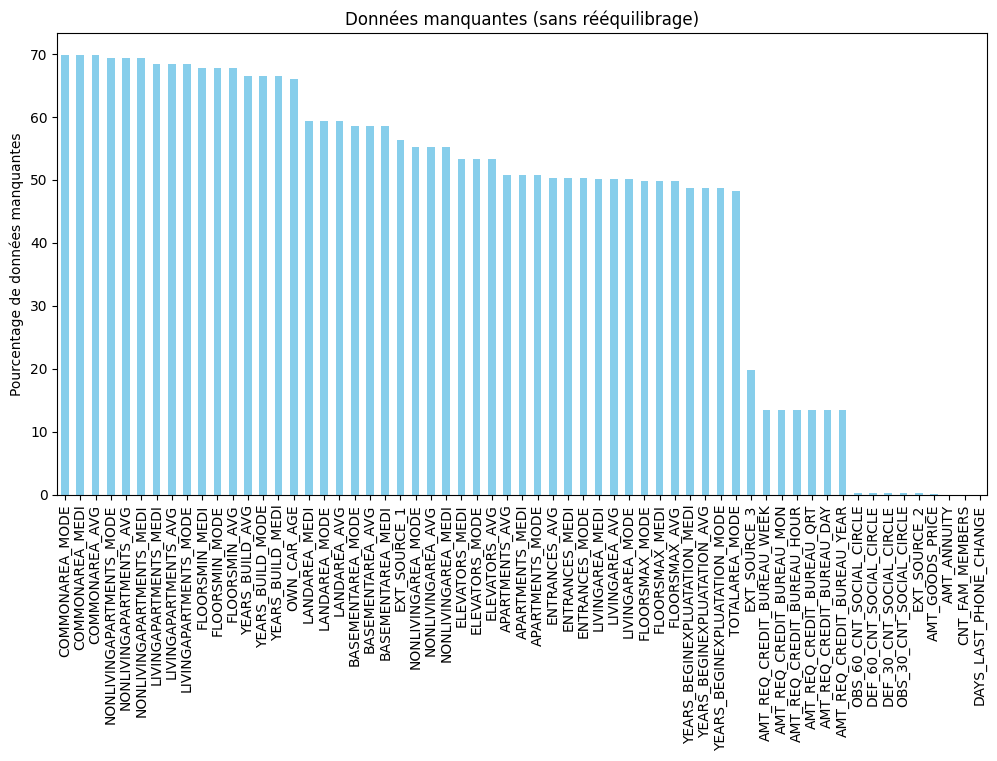

Graphique des données manquantes (avec rééquilibrage) :
Aucune donnée manquante pour Données manquantes (avec rééquilibrage).


In [409]:
import matplotlib.pyplot as plt

# Visualisation des colonnes avec données manquantes
def plot_missing_data(missing_data, title):
    filtered_data = missing_data[missing_data > 0]
    if filtered_data.empty:
        print(f"Aucune donnée manquante pour {title}.")
        return
    filtered_data.sort_values(ascending=False).plot(
        kind='bar', figsize=(12, 6), color="skyblue"
    )
    plt.title(title)
    plt.ylabel("Pourcentage de données manquantes")
    plt.show()

# Utilisation de la fonction corrigée
print("Graphique des données manquantes (sans rééquilibrage) :")
plot_missing_data(missing_no_percent, "Données manquantes (sans rééquilibrage)")

print("Graphique des données manquantes (avec rééquilibrage) :")
plot_missing_data(missing_bal_percent, "Données manquantes (avec rééquilibrage)")

In [410]:
# Suppression des colonnes avec plus de 50% de données manquantes
high_missing_cols = missing_no_percent[missing_no_percent > 50].index
X_no_balancing = X_no_balancing.drop(columns=high_missing_cols)
X_balanced = X_balanced.drop(columns=high_missing_cols)

# Supprimer les colonnes complètement vides
X_no_balancing = X_no_balancing.dropna(axis=1, how='all')
X_balanced = X_balanced.dropna(axis=1, how='all')

# Vérification des données manquantes
print("Données manquantes dans X_no_balancing :", X_no_balancing.isnull().sum().sum())
print("Données manquantes dans X_balanced :", X_balanced.isnull().sum().sum())

Données manquantes dans X_no_balancing : 1372628
Données manquantes dans X_balanced : 0


In [411]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import lightgbm as lgb
import pandas as pd
import re

In [412]:
from sklearn.model_selection import train_test_split

# Fonction pour calculer le coût métier
def calculate_business_cost(y_true, y_pred, fn_cost=10, fp_cost=1):
    """
    Calcule le coût métier basé sur les faux négatifs (FN) et faux positifs (FP).
    """
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    business_cost = fn * fn_cost + fp * fp_cost
    return business_cost

# Diviser les données sans rééquilibrage
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(
    X_no_balancing, y_no_balancing, test_size=0.3, random_state=42, stratify=y_no_balancing
)

# Diviser les données avec rééquilibrage
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
    X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced
)

# Définir les jeux de données
datasets = {
    "Sans rééquilibrage": (X_train_no, X_test_no, y_train_no, y_test_no),
    "Avec rééquilibrage": (X_train_bal, X_test_bal, y_train_bal, y_test_bal)
}

In [413]:
import mlflow

# Configurez MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Credit Scoring Model")

<Experiment: artifact_location='mlflow-artifacts:/136911579434586320', creation_time=1730232896148, experiment_id='136911579434586320', last_update_time=1730232896148, lifecycle_stage='active', name='Credit Scoring Model', tags={}>

In [414]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

def objective(params, model_type, X_train, X_test, y_train, y_test):
    print("Début de la fonction objective")

    # Démarrer un run MLflow
    with mlflow.start_run(run_name=f"{model_type} optimization"):
        print("Run MLflow démarré")
        active_run = mlflow.active_run()
        if active_run:
            print(f"Run ID actif : {active_run.info.run_id}")
        else:
            print("Erreur : Aucun run actif détecté !")

        # Nettoyage des colonnes
        print("Nettoyage des colonnes...")
        X_train = X_train.rename(columns=lambda x: re.sub(r'[^A-Za-z0-9_]', '_', x))
        X_test = X_test.rename(columns=lambda x: re.sub(r'[^A-Za-z0-9_]', '_', x))

        # Initialisation du modèle
        print(f"Initialisation du modèle {model_type}...")
        if model_type == "LightGBM":
            model = lgb.LGBMClassifier(
                n_estimators=int(params.get('n_estimators', 100)),
                num_leaves=int(params.get('num_leaves', 31)),
                learning_rate=params.get('learning_rate', 0.1),
                max_depth=int(params.get('max_depth', -1)),
                subsample=params.get('subsample', 1.0),
                colsample_bytree=params.get('colsample_bytree', 1.0),
                random_state=42
            )
        elif model_type == "RandomForest":
            model = RandomForestClassifier(
                n_estimators=int(params.get('n_estimators', 100)),
                max_depth=int(params.get('max_depth', None)),
                min_samples_split=params.get('min_samples_split', 2),
                min_samples_leaf=params.get('min_samples_leaf', 1),
                random_state=42
            )
        elif model_type == "LogisticRegression":
            model = LogisticRegression(
                C=params.get('C', 1.0),
                solver=params.get('solver', 'lbfgs'),
                max_iter=1000,
                random_state=42
            )
        else:
            raise ValueError("Type de modèle non supporté : {}".format(model_type))

        print("Entraînement du modèle...")
        model.fit(X_train, y_train)

        print("Calcul des métriques...")
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= 0.5).astype(int)

        # Calcul des métriques pertinentes
        auc = roc_auc_score(y_test, y_proba)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        # Calcul du coût métier
        business_cost = calculate_business_cost(y_test, y_pred)

        # Log des métriques dans MLflow
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Precision", precision)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("F1-Score", f1)
        mlflow.log_metric("Business Cost", business_cost)

        print(f"Métriques loguées : AUC={auc}, Accuracy={accuracy}, Precision={precision}, Recall={recall}, F1-Score={f1}, Business Cost={business_cost}")

        # Enregistrement du modèle dans MLflow
        mlflow.sklearn.log_model(model, f"{model_type}_Model")

        print(f"Run ID final pour le Model Registry : {mlflow.active_run().info.run_id}")

        return {
            'loss': -auc,  # AUC négatif pour minimisation
            'status': STATUS_OK,
            'auc': auc,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'business_cost': business_cost
        }

In [415]:
# Espace des hyperparamètres
param_space_lgb = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 10),
    'num_leaves': hp.quniform('num_leaves', 20, 50, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'max_depth': hp.quniform('max_depth', -1, 10, 1),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0)
}


In [416]:
# Définir les jeux de données
datasets = {
    "Sans rééquilibrage": (X_train_no, X_test_no, y_train_no, y_test_no),
    "Avec rééquilibrage": (X_train_bal, X_test_bal, y_train_bal, y_test_bal)
}

# Tester chaque jeu de données
for name, (X_train, X_test, y_train, y_test) in datasets.items():
    print(f"Optimisation pour le dataset : {name}")
    
    trials_lgb = Trials()
    best_params_lgb = fmin(
        fn=lambda params: objective(params, "LightGBM", X_train, X_test, y_train, y_test),
        space=param_space_lgb,
        algo=tpe.suggest,
        max_evals=50,
        trials=trials_lgb
    )
    
    print(f"Meilleurs hyperparamètres pour {name} :", best_params_lgb)

Optimisation pour le dataset : Sans rééquilibrage
Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 617ab65a677a48a7954a4f68d3c0ce22                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.181455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of 

2024/11/24 14:25:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 617ab65a677a48a7954a4f68d3c0ce22          
  0%|                                    | 0/50 [00:39<?, ?trial/s, best loss=?]

2024/11/24 14:25:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/617ab65a677a48a7954a4f68d3c0ce22.

2024/11/24 14:25:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 3c186ee85d1f4d36883bb8bff4fd9657                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.160038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:25:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 3c186ee85d1f4d36883bb8bff4fd9657          
  2%|▏         | 1/50 [01:11<32:01, 39.22s/trial, best loss: -0.736234971480875]

2024/11/24 14:25:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/3c186ee85d1f4d36883bb8bff4fd9657.

2024/11/24 14:25:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 3fc4b7beddd140e9831b0a7c174a5991                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.173328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:26:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 3fc4b7beddd140e9831b0a7c174a5991          
  4%|▎        | 2/50 [01:51<28:07, 35.15s/trial, best loss: -0.7528684299438413]

2024/11/24 14:26:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/3fc4b7beddd140e9831b0a7c174a5991.

2024/11/24 14:26:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 21290026dfa74fd7a09ac924d099d9cd                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.145250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:26:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 21290026dfa74fd7a09ac924d099d9cd          
  6%|▌        | 3/50 [02:18<29:22, 37.49s/trial, best loss: -0.7528684299438413]

2024/11/24 14:26:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/21290026dfa74fd7a09ac924d099d9cd.

2024/11/24 14:26:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 444af1237e924cf1a5b7374c78df3e74                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:27:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 444af1237e924cf1a5b7374c78df3e74          
  8%|▋        | 4/50 [02:36<25:29, 33.25s/trial, best loss: -0.7528684299438413]

2024/11/24 14:27:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/444af1237e924cf1a5b7374c78df3e74.

2024/11/24 14:27:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 9cb7f6cfea27431793c82b715bb91f95                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.145912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:27:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 9cb7f6cfea27431793c82b715bb91f95          
 10%|▉        | 5/50 [02:55<20:56, 27.92s/trial, best loss: -0.7528684299438413]

2024/11/24 14:27:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/9cb7f6cfea27431793c82b715bb91f95.

2024/11/24 14:27:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 7009c208388b4238a71b734943d5ddf2                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.216767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:27:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 7009c208388b4238a71b734943d5ddf2          
 12%|█        | 6/50 [03:14<18:05, 24.68s/trial, best loss: -0.7528684299438413]

2024/11/24 14:27:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/7009c208388b4238a71b734943d5ddf2.

2024/11/24 14:27:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : e573b42108094297b109cdadea666b8e                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.136563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:28:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : e573b42108094297b109cdadea666b8e          
 14%|█▎       | 7/50 [03:32<16:24, 22.89s/trial, best loss: -0.7528684299438413]

2024/11/24 14:28:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/e573b42108094297b109cdadea666b8e.

2024/11/24 14:28:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 64d6ad669cf84047ae8603b7da7bd71a                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.131226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:28:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 64d6ad669cf84047ae8603b7da7bd71a          
 16%|█▍       | 8/50 [03:47<14:54, 21.30s/trial, best loss: -0.7528684299438413]

2024/11/24 14:28:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/64d6ad669cf84047ae8603b7da7bd71a.

2024/11/24 14:28:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : b382824496894e1f83550927fa3d896a                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.130956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:28:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : b382824496894e1f83550927fa3d896a          
 18%|█▌       | 9/50 [04:05<13:19, 19.51s/trial, best loss: -0.7528684299438413]

2024/11/24 14:28:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/b382824496894e1f83550927fa3d896a.

2024/11/24 14:28:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 172690ee327d4dcdab44db7740128d2b                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:28:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 172690ee327d4dcdab44db7740128d2b          
 20%|█▌      | 10/50 [04:21<12:39, 18.99s/trial, best loss: -0.7528684299438413]

2024/11/24 14:28:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/172690ee327d4dcdab44db7740128d2b.

2024/11/24 14:28:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : e3ed327dc6394559994b4c2438960d24                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:29:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : e3ed327dc6394559994b4c2438960d24          
 22%|█▊      | 11/50 [04:40<11:45, 18.09s/trial, best loss: -0.7528684299438413]

2024/11/24 14:29:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/e3ed327dc6394559994b4c2438960d24.

2024/11/24 14:29:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 1ffed52c6acc44268fd87b7c2832927d                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:29:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 1ffed52c6acc44268fd87b7c2832927d          
 24%|█▉      | 12/50 [04:56<11:36, 18.32s/trial, best loss: -0.7528684299438413]

2024/11/24 14:29:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/1ffed52c6acc44268fd87b7c2832927d.

2024/11/24 14:29:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : fcdd5a238f51491fa09512a2e906cd3a                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:29:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : fcdd5a238f51491fa09512a2e906cd3a          
 26%|██      | 13/50 [05:06<10:46, 17.48s/trial, best loss: -0.7533859486919448]

2024/11/24 14:29:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/fcdd5a238f51491fa09512a2e906cd3a.

2024/11/24 14:29:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 9346d26c210d4137ab4a0d1a14857c5d                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:29:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 9346d26c210d4137ab4a0d1a14857c5d          
 28%|██▏     | 14/50 [05:20<09:15, 15.42s/trial, best loss: -0.7533859486919448]

2024/11/24 14:29:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/9346d26c210d4137ab4a0d1a14857c5d.

2024/11/24 14:29:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 8fe0015c79b54152a3086b1f6513a426                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:30:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 8fe0015c79b54152a3086b1f6513a426          
 30%|██▍     | 15/50 [05:39<08:44, 14.98s/trial, best loss: -0.7533859486919448]

2024/11/24 14:30:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/8fe0015c79b54152a3086b1f6513a426.

2024/11/24 14:30:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 34ed565c16de4236b70511728e294fe5                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:30:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 34ed565c16de4236b70511728e294fe5          
 32%|██▌     | 16/50 [05:52<09:05, 16.04s/trial, best loss: -0.7545599350870766]

2024/11/24 14:30:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/34ed565c16de4236b70511728e294fe5.

2024/11/24 14:30:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 59d15647b97740d2abe1c84b17bc1f6c                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:30:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 59d15647b97740d2abe1c84b17bc1f6c          
 34%|██▋     | 17/50 [06:08<08:18, 15.09s/trial, best loss: -0.7545599350870766]

2024/11/24 14:30:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/59d15647b97740d2abe1c84b17bc1f6c.

2024/11/24 14:30:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : cc237768fa0443ffa9d069d0f322ac32                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.205894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:31:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : cc237768fa0443ffa9d069d0f322ac32          
 36%|██▉     | 18/50 [06:27<08:13, 15.41s/trial, best loss: -0.7545599350870766]

2024/11/24 14:31:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/cc237768fa0443ffa9d069d0f322ac32.

2024/11/24 14:31:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 66dd632c01144dfb90cf547479b11334                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.126022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:31:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 66dd632c01144dfb90cf547479b11334          
 38%|███     | 19/50 [06:46<08:27, 16.37s/trial, best loss: -0.7545599350870766]

2024/11/24 14:31:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/66dd632c01144dfb90cf547479b11334.

2024/11/24 14:31:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : aa25ea5f3af84ba6bbc754ed225a1965                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:31:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : aa25ea5f3af84ba6bbc754ed225a1965          
 40%|███▏    | 20/50 [07:08<08:40, 17.34s/trial, best loss: -0.7545599350870766]

2024/11/24 14:31:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/aa25ea5f3af84ba6bbc754ed225a1965.

2024/11/24 14:31:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 0dcdcf89172e4bf48ee2b72b8d4e8907                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.265782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:32:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 0dcdcf89172e4bf48ee2b72b8d4e8907          
 42%|███▎    | 21/50 [07:33<09:02, 18.71s/trial, best loss: -0.7545599350870766]

2024/11/24 14:32:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/0dcdcf89172e4bf48ee2b72b8d4e8907.

2024/11/24 14:32:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : b5c2a46719b64bcfb8c3277993804526                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.252111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080727 -> initscore=-2.432513 
[LightGBM] [In

2024/11/24 14:32:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : b5c2a46719b64bcfb8c3277993804526          
 44%|███▌    | 22/50 [07:53<09:36, 20.57s/trial, best loss: -0.7545599350870766]

2024/11/24 14:32:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/b5c2a46719b64bcfb8c3277993804526.

2024/11/24 14:32:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : decc4183943a4523b150c79b5604406c                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080727 -> initscore=-2.432513 
[LightGBM] [In

2024/11/24 14:32:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : decc4183943a4523b150c79b5604406c          
 46%|███▋    | 23/50 [08:08<09:09, 20.35s/trial, best loss: -0.7545599350870766]

2024/11/24 14:32:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/decc4183943a4523b150c79b5604406c.

2024/11/24 14:32:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : ff2fe535153f449c85f992f8800872d9                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.131276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:32:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : ff2fe535153f449c85f992f8800872d9          
 48%|███▊    | 24/50 [08:21<08:07, 18.74s/trial, best loss: -0.7545599350870766]

2024/11/24 14:32:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/ff2fe535153f449c85f992f8800872d9.

2024/11/24 14:32:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 1bbd6f94b714466f8ff32fdce9ea70ed                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:33:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 1bbd6f94b714466f8ff32fdce9ea70ed          
 50%|████    | 25/50 [08:39<07:07, 17.11s/trial, best loss: -0.7545599350870766]

2024/11/24 14:33:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/1bbd6f94b714466f8ff32fdce9ea70ed.

2024/11/24 14:33:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : fd6e5a64a69d46a3bdeb38525c6cd0ac                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.097087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:33:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : fd6e5a64a69d46a3bdeb38525c6cd0ac          
 52%|████▏   | 26/50 [08:55<06:54, 17.26s/trial, best loss: -0.7545599350870766]

2024/11/24 14:33:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/fd6e5a64a69d46a3bdeb38525c6cd0ac.

2024/11/24 14:33:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 43948fcac3f0400987663a39c08b34bf                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:33:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 43948fcac3f0400987663a39c08b34bf          
 54%|████▎   | 27/50 [09:12<06:32, 17.07s/trial, best loss: -0.7545599350870766]

2024/11/24 14:33:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/43948fcac3f0400987663a39c08b34bf.

2024/11/24 14:33:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 009f8654814a4f40b61301b4208e2de4                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.116410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:34:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 009f8654814a4f40b61301b4208e2de4          
 56%|████▍   | 28/50 [09:30<06:13, 16.96s/trial, best loss: -0.7545599350870766]

2024/11/24 14:34:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/009f8654814a4f40b61301b4208e2de4.

2024/11/24 14:34:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : b70770a4151a48d3a758409a66bac8a1                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.190316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:34:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : b70770a4151a48d3a758409a66bac8a1          
 58%|████▋   | 29/50 [09:47<06:02, 17.26s/trial, best loss: -0.7545599350870766]

2024/11/24 14:34:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/b70770a4151a48d3a758409a66bac8a1.

2024/11/24 14:34:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : c2824426f54f49edbdba9cf997768ae8                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:34:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : c2824426f54f49edbdba9cf997768ae8          
 60%|████▊   | 30/50 [10:04<05:42, 17.11s/trial, best loss: -0.7545599350870766]

2024/11/24 14:34:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/c2824426f54f49edbdba9cf997768ae8.

2024/11/24 14:34:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : c56de3d3621d488fb1f52e1cec41bb0f                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.308353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080727 -> initscore=-2.432513 
[LightGBM] [In

2024/11/24 14:35:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : c56de3d3621d488fb1f52e1cec41bb0f          
 62%|████▉   | 31/50 [10:28<05:24, 17.09s/trial, best loss: -0.7545599350870766]

2024/11/24 14:35:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/c56de3d3621d488fb1f52e1cec41bb0f.

2024/11/24 14:35:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 66cf28983e8948c086463382b52fad98                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.261464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:35:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 66cf28983e8948c086463382b52fad98          
 64%|█████   | 32/50 [10:52<05:44, 19.16s/trial, best loss: -0.7545599350870766]

2024/11/24 14:35:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/66cf28983e8948c086463382b52fad98.

2024/11/24 14:35:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : bfadd52ae802486489975447beae9454                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:35:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : bfadd52ae802486489975447beae9454          
 66%|█████▎  | 33/50 [11:13<05:50, 20.60s/trial, best loss: -0.7545599350870766]

2024/11/24 14:35:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/bfadd52ae802486489975447beae9454.

2024/11/24 14:35:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 5dd0f068d7c1483982618e57f05b322d                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:36:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 5dd0f068d7c1483982618e57f05b322d          
 68%|█████▍  | 34/50 [11:34<05:31, 20.74s/trial, best loss: -0.7545599350870766]

2024/11/24 14:36:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/5dd0f068d7c1483982618e57f05b322d.

2024/11/24 14:36:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : efb09595a06543d59b0b0b0630aa165a                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:36:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : efb09595a06543d59b0b0b0630aa165a          
 70%|█████▌  | 35/50 [11:55<05:13, 20.87s/trial, best loss: -0.7545599350870766]

2024/11/24 14:36:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/efb09595a06543d59b0b0b0630aa165a.

2024/11/24 14:36:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 1d4f3dcbae084c518e3bed664836da84                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:36:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 1d4f3dcbae084c518e3bed664836da84          
 72%|█████▊  | 36/50 [12:14<04:51, 20.79s/trial, best loss: -0.7545599350870766]

2024/11/24 14:36:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/1d4f3dcbae084c518e3bed664836da84.

2024/11/24 14:36:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 292adfa725134941bd936d7d9de66a5c                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:37:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 292adfa725134941bd936d7d9de66a5c          
 74%|█████▉  | 37/50 [12:36<04:26, 20.51s/trial, best loss: -0.7545599350870766]

2024/11/24 14:37:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/292adfa725134941bd936d7d9de66a5c.

2024/11/24 14:37:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : edf12296e2e34f2e90cacda9b075aed1                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.158417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:37:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : edf12296e2e34f2e90cacda9b075aed1          
 76%|██████  | 38/50 [12:54<04:09, 20.81s/trial, best loss: -0.7545599350870766]

2024/11/24 14:37:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/edf12296e2e34f2e90cacda9b075aed1.

2024/11/24 14:37:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : a83f2a6c1bc440589dd7d6566077dc6a                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:37:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : a83f2a6c1bc440589dd7d6566077dc6a          
 78%|██████▏ | 39/50 [13:10<03:38, 19.87s/trial, best loss: -0.7545599350870766]

2024/11/24 14:37:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/a83f2a6c1bc440589dd7d6566077dc6a.

2024/11/24 14:37:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 6eb5e48a2f8f4a0b97492204781f3418                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.147018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:37:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 6eb5e48a2f8f4a0b97492204781f3418          
 80%|██████▍ | 40/50 [13:25<03:08, 18.81s/trial, best loss: -0.7545599350870766]

2024/11/24 14:37:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/6eb5e48a2f8f4a0b97492204781f3418.

2024/11/24 14:37:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : b930bd0abf8b4c4fa1586c16d3c7ad09                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:38:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : b930bd0abf8b4c4fa1586c16d3c7ad09          
 82%|██████▌ | 41/50 [13:44<02:38, 17.59s/trial, best loss: -0.7545599350870766]

2024/11/24 14:38:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/b930bd0abf8b4c4fa1586c16d3c7ad09.

2024/11/24 14:38:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 10d55d587198497fb8464393f7838aa9                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:38:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 10d55d587198497fb8464393f7838aa9          
 84%|██████▋ | 42/50 [14:01<02:24, 18.04s/trial, best loss: -0.7545599350870766]

2024/11/24 14:38:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/10d55d587198497fb8464393f7838aa9.

2024/11/24 14:38:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 2467f426a41d4c309b48fd4c6cd64b31                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.123330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:38:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 2467f426a41d4c309b48fd4c6cd64b31          
 86%|██████▉ | 43/50 [14:17<02:05, 17.89s/trial, best loss: -0.7545599350870766]

2024/11/24 14:38:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/2467f426a41d4c309b48fd4c6cd64b31.

2024/11/24 14:38:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 2e59d750ede74631970d64b133634c86                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.143664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:39:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 2e59d750ede74631970d64b133634c86          
 88%|███████ | 44/50 [14:33<01:43, 17.29s/trial, best loss: -0.7545599350870766]

2024/11/24 14:39:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/2e59d750ede74631970d64b133634c86.

2024/11/24 14:39:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : c20a6dea89d84486be8b8f1c07a938fe                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:39:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : c20a6dea89d84486be8b8f1c07a938fe          
 90%|███████▏| 45/50 [14:50<01:23, 16.74s/trial, best loss: -0.7545599350870766]

2024/11/24 14:39:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/c20a6dea89d84486be8b8f1c07a938fe.

2024/11/24 14:39:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : b5347f5861884d1081dedeb2cc17ab1b                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:39:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : b5347f5861884d1081dedeb2cc17ab1b          
 92%|███████▎| 46/50 [15:05<01:07, 16.98s/trial, best loss: -0.7545599350870766]

2024/11/24 14:39:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/b5347f5861884d1081dedeb2cc17ab1b.

2024/11/24 14:39:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 9a7e9d7c98c84ef9ba5d31a519c69f7c                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:39:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 9a7e9d7c98c84ef9ba5d31a519c69f7c          
 94%|███████▌| 47/50 [15:19<00:48, 16.28s/trial, best loss: -0.7545599350870766]

2024/11/24 14:39:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/9a7e9d7c98c84ef9ba5d31a519c69f7c.

2024/11/24 14:39:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 9e1702dbdc7d44e3be6074338f9dff39                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:40:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 9e1702dbdc7d44e3be6074338f9dff39          
 96%|███████▋| 48/50 [15:34<00:31, 15.75s/trial, best loss: -0.7545599350870766]

2024/11/24 14:40:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/9e1702dbdc7d44e3be6074338f9dff39.

2024/11/24 14:40:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : c93d7f4eac3f47b6922cb2b080dbddb8                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.104847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601                                               
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 201
[LightGBM] [Info] [binary:Boost

2024/11/24 14:40:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : c93d7f4eac3f47b6922cb2b080dbddb8          
 98%|███████▊| 49/50 [15:47<00:15, 15.53s/trial, best loss: -0.7545599350870766]

2024/11/24 14:40:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/c93d7f4eac3f47b6922cb2b080dbddb8.

2024/11/24 14:40:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



100%|████████| 50/50 [15:47<00:00, 18.94s/trial, best loss: -0.7545599350870766]
Meilleurs hyperparamètres pour Sans rééquilibrage : {'colsample_bytree': 0.7301469956118631, 'learning_rate': 0.06808594120792424, 'max_depth': 7.0, 'n_estimators': 190.0, 'num_leaves': 27.0, 'subsample': 0.8921019692836318}
Optimisation pour le dataset : Avec rééquilibrage
Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 7d4b1ac6fd294706953c9f5e82a53084                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of tes

2024/11/24 14:40:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 7d4b1ac6fd294706953c9f5e82a53084          
  0%|                                    | 0/50 [00:26<?, ?trial/s, best loss=?]

2024/11/24 14:40:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/7d4b1ac6fd294706953c9f5e82a53084.

2024/11/24 14:40:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 4ebf8a407470404bb07654f5ac15ee17                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.180687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:41:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 4ebf8a407470404bb07654f5ac15ee17          
  2%|▏        | 1/50 [00:53<21:22, 26.16s/trial, best loss: -0.9784721447134966]

2024/11/24 14:41:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/4ebf8a407470404bb07654f5ac15ee17.

2024/11/24 14:41:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 4657702366b74f1794a1adb7fdcd5024                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.225111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:41:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 4657702366b74f1794a1adb7fdcd5024          
  4%|▎        | 2/50 [01:15<21:31, 26.92s/trial, best loss: -0.9784721447134966]

2024/11/24 14:41:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/4657702366b74f1794a1adb7fdcd5024.

2024/11/24 14:41:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 910190c2ee1d45a284ad1060be0cb527                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.272727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:41:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 910190c2ee1d45a284ad1060be0cb527          
  6%|▌        | 3/50 [01:33<19:12, 24.53s/trial, best loss: -0.9785848088551108]

2024/11/24 14:41:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/910190c2ee1d45a284ad1060be0cb527.

2024/11/24 14:41:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : b6efd1315c4d4f22919a0745b3ca4683                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.181496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:42:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : b6efd1315c4d4f22919a0745b3ca4683          
  8%|▋        | 4/50 [01:50<17:04, 22.27s/trial, best loss: -0.9785848088551108]

2024/11/24 14:42:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/b6efd1315c4d4f22919a0745b3ca4683.

2024/11/24 14:42:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 7ba13a879b514cb3ad2cdc1d137a9c56                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.261462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:42:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 7ba13a879b514cb3ad2cdc1d137a9c56          
 10%|▉        | 5/50 [02:05<15:05, 20.13s/trial, best loss: -0.9785848088551108]

2024/11/24 14:42:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/7ba13a879b514cb3ad2cdc1d137a9c56.

2024/11/24 14:42:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 19b8b06e90004dcb9763bbb4a560d861                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.243939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:42:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 19b8b06e90004dcb9763bbb4a560d861          
 12%|█        | 6/50 [02:28<13:28, 18.39s/trial, best loss: -0.9785848088551108]

2024/11/24 14:42:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/19b8b06e90004dcb9763bbb4a560d861.

2024/11/24 14:42:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : f5feae57a0a941399d85ec6bad59df16                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.185975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:43:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : f5feae57a0a941399d85ec6bad59df16          
 14%|█▎       | 7/50 [02:46<14:23, 20.08s/trial, best loss: -0.9785848088551108]

2024/11/24 14:43:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/f5feae57a0a941399d85ec6bad59df16.

2024/11/24 14:43:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 3276fa52134f46b18b3099af497468d0                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.181710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:43:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 3276fa52134f46b18b3099af497468d0          
 16%|█▍       | 8/50 [03:04<13:26, 19.19s/trial, best loss: -0.9785848088551108]

2024/11/24 14:43:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/3276fa52134f46b18b3099af497468d0.

2024/11/24 14:43:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 9f7dacd122d74d28919b2b8db1ffa4b3                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.177409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:43:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 9f7dacd122d74d28919b2b8db1ffa4b3          
 18%|█▌       | 9/50 [03:18<13:00, 19.04s/trial, best loss: -0.9785848088551108]

2024/11/24 14:43:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/9f7dacd122d74d28919b2b8db1ffa4b3.

2024/11/24 14:43:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : b7bf76f4f3b54910ac582d18cd558571                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.780093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000  
Calcul des mét

2024/11/24 14:44:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : b7bf76f4f3b54910ac582d18cd558571          
 20%|█▌      | 10/50 [03:40<11:39, 17.50s/trial, best loss: -0.9785848088551108]

2024/11/24 14:44:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/b7bf76f4f3b54910ac582d18cd558571.

2024/11/24 14:44:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : d3b5725dbfef4f048cecb78dac478c05                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.185478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:44:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : d3b5725dbfef4f048cecb78dac478c05          
 22%|█▊      | 11/50 [04:02<12:06, 18.62s/trial, best loss: -0.9785848088551108]

2024/11/24 14:44:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/d3b5725dbfef4f048cecb78dac478c05.

2024/11/24 14:44:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 9ba1c24050004fdd9e29de75f3125eff                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.317626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:44:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 9ba1c24050004fdd9e29de75f3125eff          
 24%|█▉      | 12/50 [04:23<12:31, 19.77s/trial, best loss: -0.9785848088551108]

2024/11/24 14:44:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/9ba1c24050004fdd9e29de75f3125eff.

2024/11/24 14:44:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 27cb6e928f2241d8be70a0ad66260ac3                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.194850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:45:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 27cb6e928f2241d8be70a0ad66260ac3          
 26%|██      | 13/50 [04:40<12:30, 20.29s/trial, best loss: -0.9785848088551108]

2024/11/24 14:45:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/27cb6e928f2241d8be70a0ad66260ac3.

2024/11/24 14:45:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 1cd85ab817aa422883279390f5226f3c                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.192891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:45:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 1cd85ab817aa422883279390f5226f3c          
 28%|██▏     | 14/50 [05:01<11:33, 19.26s/trial, best loss: -0.9785848088551108]

2024/11/24 14:45:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/1cd85ab817aa422883279390f5226f3c.

2024/11/24 14:45:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 075974019c1f46eb91d117dc15784f18                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.176952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:45:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 075974019c1f46eb91d117dc15784f18          
 30%|██▍     | 15/50 [05:20<11:31, 19.75s/trial, best loss: -0.9785848088551108]

2024/11/24 14:45:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/075974019c1f46eb91d117dc15784f18.

2024/11/24 14:45:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 1fb8c891f5ed4670ae0739553455aeb2                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.177204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:45:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 1fb8c891f5ed4670ae0739553455aeb2          
 32%|██▌     | 16/50 [05:34<10:56, 19.32s/trial, best loss: -0.9785848088551108]

2024/11/24 14:45:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/1fb8c891f5ed4670ae0739553455aeb2.

2024/11/24 14:45:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 43ed347b267a4decbc2e196684387750                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.185332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:46:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 43ed347b267a4decbc2e196684387750          
 34%|██▋     | 17/50 [05:49<09:51, 17.93s/trial, best loss: -0.9785848088551108]

2024/11/24 14:46:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/43ed347b267a4decbc2e196684387750.

2024/11/24 14:46:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : a8be3a876921471d9b720f11565b97cb                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.178030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:46:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : a8be3a876921471d9b720f11565b97cb          
 36%|██▉     | 18/50 [06:06<09:02, 16.95s/trial, best loss: -0.9785848088551108]

2024/11/24 14:46:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/a8be3a876921471d9b720f11565b97cb.

2024/11/24 14:46:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : dacfc8c885174495b94957e23e097418                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.229192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:46:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : dacfc8c885174495b94957e23e097418          
 38%|███     | 19/50 [06:33<08:43, 16.87s/trial, best loss: -0.9785848088551108]

2024/11/24 14:46:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/dacfc8c885174495b94957e23e097418.

2024/11/24 14:46:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 8a31fdb2423d4d8285dd17048bae51a9                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.207102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:47:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 8a31fdb2423d4d8285dd17048bae51a9          
 40%|███▏    | 20/50 [07:00<10:02, 20.08s/trial, best loss: -0.9785848088551108]

2024/11/24 14:47:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/8a31fdb2423d4d8285dd17048bae51a9.

2024/11/24 14:47:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 253e0a2339584636bc429f33f1d810fd                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.208694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:47:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 253e0a2339584636bc429f33f1d810fd          
 42%|███▎    | 21/50 [07:25<10:44, 22.21s/trial, best loss: -0.9785848088551108]

2024/11/24 14:47:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/253e0a2339584636bc429f33f1d810fd.

2024/11/24 14:47:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 51606eaf0d99404c8626456ff8f59440                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.176441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:47:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 51606eaf0d99404c8626456ff8f59440          
 44%|███▌    | 22/50 [07:39<10:45, 23.07s/trial, best loss: -0.9785848088551108]

2024/11/24 14:47:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/51606eaf0d99404c8626456ff8f59440.

2024/11/24 14:47:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 9db8058abbf24ed4a8876fc6567eef19                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.264064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:48:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 9db8058abbf24ed4a8876fc6567eef19          
 46%|███▋    | 23/50 [07:58<09:03, 20.13s/trial, best loss: -0.9785848088551108]

2024/11/24 14:48:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/9db8058abbf24ed4a8876fc6567eef19.

2024/11/24 14:48:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : c1975faa2e49493aa05d8cc8f6bfd7d5                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.169919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:48:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : c1975faa2e49493aa05d8cc8f6bfd7d5          
 48%|███▊    | 24/50 [08:15<08:39, 19.98s/trial, best loss: -0.9785848088551108]

2024/11/24 14:48:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/c1975faa2e49493aa05d8cc8f6bfd7d5.

2024/11/24 14:48:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 062159f1a4604c5f9a351bc6beeab2a7                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.171924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:48:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 062159f1a4604c5f9a351bc6beeab2a7          
 50%|████    | 25/50 [08:29<07:52, 18.88s/trial, best loss: -0.9785848088551108]

2024/11/24 14:48:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/062159f1a4604c5f9a351bc6beeab2a7.

2024/11/24 14:48:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 1dad1dcf6ae24c1ca131e42d73f1433b                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.282797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:49:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 1dad1dcf6ae24c1ca131e42d73f1433b          
 52%|████▏   | 26/50 [08:47<07:03, 17.64s/trial, best loss: -0.9785848088551108]

2024/11/24 14:49:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/1dad1dcf6ae24c1ca131e42d73f1433b.

2024/11/24 14:49:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 83489685a05b477da5cbfb70109e6f79                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.171767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:49:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 83489685a05b477da5cbfb70109e6f79          
 54%|████▎   | 27/50 [09:05<06:43, 17.54s/trial, best loss: -0.9787630711918283]

2024/11/24 14:49:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/83489685a05b477da5cbfb70109e6f79.

2024/11/24 14:49:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : d38191c6e3324e4ea2219984d69cf567                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.191977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:49:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : d38191c6e3324e4ea2219984d69cf567          
 56%|████▍   | 28/50 [09:27<06:31, 17.80s/trial, best loss: -0.9787630711918283]

2024/11/24 14:49:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/d38191c6e3324e4ea2219984d69cf567.

2024/11/24 14:49:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 01aeaf91c9fa4cd981cefaffd25c52c3                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.658947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000  
[LightGBM] [Wa

2024/11/24 14:50:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 01aeaf91c9fa4cd981cefaffd25c52c3          
 58%|████▋   | 29/50 [10:02<06:36, 18.88s/trial, best loss: -0.9787630711918283]

2024/11/24 14:50:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/01aeaf91c9fa4cd981cefaffd25c52c3.

2024/11/24 14:50:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 4cfb811cc4d94f9aa5bc5bf18a1b5ac5                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.330990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:50:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 4cfb811cc4d94f9aa5bc5bf18a1b5ac5          
 60%|████▊   | 30/50 [10:32<07:54, 23.75s/trial, best loss: -0.9787630711918283]

2024/11/24 14:50:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/4cfb811cc4d94f9aa5bc5bf18a1b5ac5.

2024/11/24 14:50:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 9d6c062ee47d4cd1a5f7d171066d60b8                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.248215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:51:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 9d6c062ee47d4cd1a5f7d171066d60b8          
 62%|████▉   | 31/50 [10:52<08:09, 25.75s/trial, best loss: -0.9787630711918283]

2024/11/24 14:51:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/9d6c062ee47d4cd1a5f7d171066d60b8.

2024/11/24 14:51:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 034522add5d54e03bea3a65cbd5bfb52                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.252681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:51:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 034522add5d54e03bea3a65cbd5bfb52          
 64%|█████   | 32/50 [11:12<07:09, 23.87s/trial, best loss: -0.9787630711918283]

2024/11/24 14:51:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/034522add5d54e03bea3a65cbd5bfb52.

2024/11/24 14:51:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : d98a8fd1afad4845af7a639348de7ede                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.604148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000  
Calcul des mét

2024/11/24 14:52:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : d98a8fd1afad4845af7a639348de7ede          
 66%|█████▎  | 33/50 [11:44<06:26, 22.74s/trial, best loss: -0.9787630711918283]

2024/11/24 14:52:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/d98a8fd1afad4845af7a639348de7ede.

2024/11/24 14:52:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : be810a060ae5481382c3b7445e806ab8                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.198645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:52:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : be810a060ae5481382c3b7445e806ab8          
 68%|█████▍  | 34/50 [12:07<06:49, 25.59s/trial, best loss: -0.9787630711918283]

2024/11/24 14:52:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/be810a060ae5481382c3b7445e806ab8.

2024/11/24 14:52:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : b9182384c80d4e058bcfc6d6f0b018c1                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.170986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:52:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : b9182384c80d4e058bcfc6d6f0b018c1          
 70%|█████▌  | 35/50 [12:28<06:12, 24.85s/trial, best loss: -0.9787630711918283]

2024/11/24 14:52:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/b9182384c80d4e058bcfc6d6f0b018c1.

2024/11/24 14:52:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 63d4e0f923c6498a8659b1b8e05efa93                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.249414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:53:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 63d4e0f923c6498a8659b1b8e05efa93          
 72%|█████▊  | 36/50 [12:52<05:33, 23.80s/trial, best loss: -0.9787630711918283]

2024/11/24 14:53:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/63d4e0f923c6498a8659b1b8e05efa93.

2024/11/24 14:53:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 311e99df121d456882acc3c2354258d2                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.186291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:53:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 311e99df121d456882acc3c2354258d2          
 74%|█████▉  | 37/50 [13:15<05:09, 23.84s/trial, best loss: -0.9787630711918283]

2024/11/24 14:53:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/311e99df121d456882acc3c2354258d2.

2024/11/24 14:53:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : ee8b1f5c3a50435e9fe37d7b11db49a6                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.220600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:53:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : ee8b1f5c3a50435e9fe37d7b11db49a6          
 76%|██████  | 38/50 [13:36<04:40, 23.37s/trial, best loss: -0.9787630711918283]

2024/11/24 14:53:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/ee8b1f5c3a50435e9fe37d7b11db49a6.

2024/11/24 14:53:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : abcaa4e6e63d41caaab8ed1b164db6ae                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.209993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:54:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : abcaa4e6e63d41caaab8ed1b164db6ae          
 78%|██████▏ | 39/50 [13:57<04:10, 22.77s/trial, best loss: -0.9787630711918283]

2024/11/24 14:54:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/abcaa4e6e63d41caaab8ed1b164db6ae.

2024/11/24 14:54:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : af70cf7bc4474011b37a92a3c7377b45                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.208604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:54:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : af70cf7bc4474011b37a92a3c7377b45          
 80%|██████▍ | 40/50 [14:21<03:41, 22.19s/trial, best loss: -0.9787630711918283]

2024/11/24 14:54:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/af70cf7bc4474011b37a92a3c7377b45.

2024/11/24 14:54:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 03c39501ab094fa594fe209d14b3d247                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.201702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:55:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 03c39501ab094fa594fe209d14b3d247          
 82%|██████▌ | 41/50 [14:45<03:24, 22.74s/trial, best loss: -0.9787630711918283]

2024/11/24 14:55:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/03c39501ab094fa594fe209d14b3d247.

2024/11/24 14:55:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 38204893ef7b416eba470fea2220cdd2                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.269982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:55:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 38204893ef7b416eba470fea2220cdd2          
 84%|██████▋ | 42/50 [15:08<03:04, 23.08s/trial, best loss: -0.9787630711918283]

2024/11/24 14:55:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/38204893ef7b416eba470fea2220cdd2.

2024/11/24 14:55:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 459dd365d6204afc938054e39570510b                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.223926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:55:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 459dd365d6204afc938054e39570510b          
 86%|██████▉ | 43/50 [15:38<02:41, 23.12s/trial, best loss: -0.9787630711918283]

2024/11/24 14:55:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/459dd365d6204afc938054e39570510b.

2024/11/24 14:55:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : a486d1f4726d426f89104406b6a2698b                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.718018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:56:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : a486d1f4726d426f89104406b6a2698b          
 88%|███████ | 44/50 [16:29<02:32, 25.38s/trial, best loss: -0.9787630711918283]

2024/11/24 14:56:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/a486d1f4726d426f89104406b6a2698b.

2024/11/24 14:56:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : f4a78da0d1514319a454db649bb994c3                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.344428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:57:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : f4a78da0d1514319a454db649bb994c3          
 90%|███████▏| 45/50 [17:08<02:44, 32.99s/trial, best loss: -0.9787630711918283]

2024/11/24 14:57:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/f4a78da0d1514319a454db649bb994c3.

2024/11/24 14:57:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : f2fd54a204784c6d92e0d3d985b5e652                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.374849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 14:58:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : f2fd54a204784c6d92e0d3d985b5e652          
 92%|███████▎| 46/50 [17:47<02:18, 34.64s/trial, best loss: -0.9787630711918283]

2024/11/24 14:58:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/f2fd54a204784c6d92e0d3d985b5e652.

2024/11/24 14:58:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 787598be4ea8457dad9e2d20aa654c65                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.807196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 15:01:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 787598be4ea8457dad9e2d20aa654c65          
 94%|███████▌| 47/50 [21:37<01:48, 36.08s/trial, best loss: -0.9787630711918283]

2024/11/24 15:01:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/787598be4ea8457dad9e2d20aa654c65.

2024/11/24 15:01:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 77fa54ccb21c4193bf58def1f876cfd3                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.670921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 15:03:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 77fa54ccb21c4193bf58def1f876cfd3          
 96%|███████▋| 48/50 [22:47<03:08, 94.21s/trial, best loss: -0.9787630711918283]

2024/11/24 15:03:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/77fa54ccb21c4193bf58def1f876cfd3.

2024/11/24 15:03:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 87c1a829a1874212ae7bb6b8501f29e3                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.200812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8242                                               
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 203
[LightGBM] [Info] [binary:Boost

2024/11/24 15:09:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 87c1a829a1874212ae7bb6b8501f29e3          
 98%|███████▊| 49/50 [29:10<01:26, 86.82s/trial, best loss: -0.9787630711918283]

2024/11/24 15:09:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/87c1a829a1874212ae7bb6b8501f29e3.

2024/11/24 15:09:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



100%|████████| 50/50 [29:10<00:00, 35.02s/trial, best loss: -0.9787630711918283]
Meilleurs hyperparamètres pour Avec rééquilibrage : {'colsample_bytree': 0.9682485126510698, 'learning_rate': 0.13219597479522296, 'max_depth': -1.0, 'n_estimators': 130.0, 'num_leaves': 29.0, 'subsample': 0.9693374825657533}


In [417]:
# Optimisation des hyperparamètres pour Random Forest
print("Optimisation des hyperparamètres pour Random Forest...")

param_space_rf = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 10),
    'max_depth': hp.quniform('max_depth', 5, 30, 1),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5)
}

trials_rf = Trials()
best_params_rf = fmin(
    fn=lambda params: objective(params, "RandomForest", X_train, X_test, y_train, y_test),
    space=param_space_rf,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials_rf
)

print("Meilleurs hyperparamètres pour Random Forest :", best_params_rf)

Optimisation des hyperparamètres pour Random Forest...
Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : ebd5d94f068f40249e635569cf0993f7                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.8438059844129981, Accuracy=0.7641322547932929, Precision=0.7722146607038693, Recall=0.7492866070796877, F1-Score=0.7605778783199876, Business Cost=231364
  0%|                                    | 0/50 [01:20<?, ?trial/s, best loss=?]

2024/11/24 15:11:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : ebd5d94f068f40249e635569cf0993f7          
  0%|                                    | 0/50 [01:42<?, ?trial/s, best loss=?]

2024/11/24 15:11:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/ebd5d94f068f40249e635569cf0993f7.

2024/11/24 15:11:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 01873465b9c2407cbf6bd2096eda0610                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.5, Accuracy=0.5, Precision=0.5, Recall=1.0, F1-Score=0.6666666666666666, Business Cost=84806
  2%|      | 1/50 [02:38<1:23:34, 102.34s/trial, best loss: -0.8438059844129981]

2024/11/24 15:12:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 01873465b9c2407cbf6bd2096eda0610          
  2%|      | 1/50 [02:55<1:23:34, 102.34s/trial, best loss: -0.8438059844129981]

2024/11/24 15:12:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/01873465b9c2407cbf6bd2096eda0610.

2024/11/24 15:12:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : afaa5b70cca448d795e2bd7e5ed4f09c                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.7079887708369305, Accuracy=0.6519644836450251, Precision=0.6518624135371127, Recall=0.6523005447727755, F1-Score=0.6520814055602379, Business Cost=324414
  4%|▎      | 2/50 [03:50<1:08:05, 85.11s/trial, best loss: -0.8438059844129981]

2024/11/24 15:13:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : afaa5b70cca448d795e2bd7e5ed4f09c          
  4%|▎      | 2/50 [04:02<1:08:05, 85.11s/trial, best loss: -0.8438059844129981]

2024/11/24 15:13:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/afaa5b70cca448d795e2bd7e5ed4f09c.

2024/11/24 15:13:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : c51172ea64bf4dd8a8dcab47c2554edf                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.5, Accuracy=0.5, Precision=0.0, Recall=0.0, F1-Score=0.0, Business Cost=848060
  6%|▍      | 3/50 [04:35<1:00:29, 77.21s/trial, best loss: -0.8438059844129981]

2024/11/24 15:14:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : c51172ea64bf4dd8a8dcab47c2554edf          
  6%|▍      | 3/50 [04:44<1:00:29, 77.21s/trial, best loss: -0.8438059844129981]

2024/11/24 15:14:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/c51172ea64bf4dd8a8dcab47c2554edf.

2024/11/24 15:14:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 5da0acfc9620444f8d6ed2ba72490547                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.5, Accuracy=0.5, Precision=0.5, Recall=1.0, F1-Score=0.6666666666666666, Business Cost=84806
  8%|▋        | 4/50 [05:13<48:31, 63.30s/trial, best loss: -0.8438059844129981]

2024/11/24 15:14:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 5da0acfc9620444f8d6ed2ba72490547          
  8%|▋        | 4/50 [05:25<48:31, 63.30s/trial, best loss: -0.8438059844129981]

2024/11/24 15:14:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/5da0acfc9620444f8d6ed2ba72490547.

2024/11/24 15:14:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : d5a98915ffbd4a3aa5a224961c156d1d                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.5, Accuracy=0.5, Precision=0.5, Recall=1.0, F1-Score=0.6666666666666666, Business Cost=84806
 10%|▉        | 5/50 [05:48<41:12, 54.94s/trial, best loss: -0.8438059844129981]

2024/11/24 15:15:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : d5a98915ffbd4a3aa5a224961c156d1d          
 10%|▉        | 5/50 [06:07<41:12, 54.94s/trial, best loss: -0.8438059844129981]

2024/11/24 15:15:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/d5a98915ffbd4a3aa5a224961c156d1d.

2024/11/24 15:15:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : f29812dcd53c411992e9aa411bd5d678                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.8426696315201776, Accuracy=0.763625215197038, Precision=0.7685654565985153, Recall=0.754427752753343, F1-Score=0.7614309856472996, Business Cost=227526
 12%|█        | 6/50 [07:14<37:13, 50.75s/trial, best loss: -0.8438059844129981]

2024/11/24 15:17:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : f29812dcd53c411992e9aa411bd5d678          
 12%|█        | 6/50 [07:29<37:13, 50.75s/trial, best loss: -0.8438059844129981]

2024/11/24 15:17:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/f29812dcd53c411992e9aa411bd5d678.

2024/11/24 15:17:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 42b3708aaf2f4954aff49655dff42610                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.5, Accuracy=0.5, Precision=0.5, Recall=1.0, F1-Score=0.6666666666666666, Business Cost=84806
 14%|█▎       | 7/50 [07:53<43:36, 60.84s/trial, best loss: -0.8438059844129981]

2024/11/24 15:17:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 42b3708aaf2f4954aff49655dff42610          
 14%|█▎       | 7/50 [08:01<43:36, 60.84s/trial, best loss: -0.8438059844129981]

2024/11/24 15:17:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/42b3708aaf2f4954aff49655dff42610.

2024/11/24 15:17:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : a85e82802e7c4f7a82b3d175bf662e76                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.8744997137561871, Accuracy=0.7912883522392283, Precision=0.8041941680622599, Recall=0.770075230526142, F1-Score=0.7867649716288988, Business Cost=210891
 16%|█▍       | 8/50 [08:31<36:15, 51.80s/trial, best loss: -0.8438059844129981]

2024/11/24 15:18:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : a85e82802e7c4f7a82b3d175bf662e76          
 16%|█▍       | 8/50 [08:35<36:15, 51.80s/trial, best loss: -0.8438059844129981]

2024/11/24 15:18:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/a85e82802e7c4f7a82b3d175bf662e76.

2024/11/24 15:18:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : a131e6ebd74c438fbc0976b092e9c4e8                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.8782751390064083, Accuracy=0.7961818739240148, Precision=0.8091598355611354, Recall=0.7751927929627621, F1-Score=0.7918122034061619, Business Cost=206155
 18%|█▌       | 9/50 [09:24<31:36, 46.25s/trial, best loss: -0.8744997137561871]

2024/11/24 15:19:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : a131e6ebd74c438fbc0976b092e9c4e8          
 18%|█▌       | 9/50 [09:30<31:36, 46.25s/trial, best loss: -0.8744997137561871]

2024/11/24 15:19:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/a131e6ebd74c438fbc0976b092e9c4e8.

2024/11/24 15:19:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : e6a256242df84b648a6a246c40e90b14                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.8277631731843368, Accuracy=0.7514798481239535, Precision=0.7556090896016108, Recall=0.7434025894394265, F1-Score=0.7494561405594322, Business Cost=238001
 20%|█▌      | 10/50 [10:03<32:33, 48.84s/trial, best loss: -0.8782751390064083]

2024/11/24 15:19:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : e6a256242df84b648a6a246c40e90b14          
 20%|█▌      | 10/50 [10:08<32:33, 48.84s/trial, best loss: -0.8782751390064083]

2024/11/24 15:19:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/e6a256242df84b648a6a246c40e90b14.

2024/11/24 15:19:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : a340ef79d01b41c0b78c974d49fe77ec                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.5, Accuracy=0.5, Precision=0.0, Recall=0.0, F1-Score=0.0, Business Cost=848060
 22%|█▊      | 11/50 [10:25<29:37, 45.58s/trial, best loss: -0.8782751390064083]

2024/11/24 15:20:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : a340ef79d01b41c0b78c974d49fe77ec          
 22%|█▊      | 11/50 [10:30<29:37, 45.58s/trial, best loss: -0.8782751390064083]

2024/11/24 15:20:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/a340ef79d01b41c0b78c974d49fe77ec.

2024/11/24 15:20:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 60f6806bc8234616ae3a300eb8231851                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.863948734767898, Accuracy=0.7820496191307219, Precision=0.7865537359385669, Recall=0.7741905053887697, F1-Score=0.7803231538100417, Business Cost=209317
 24%|█▉      | 12/50 [11:03<24:16, 38.32s/trial, best loss: -0.8782751390064083]

2024/11/24 15:20:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 60f6806bc8234616ae3a300eb8231851          
 24%|█▉      | 12/50 [11:15<24:16, 38.32s/trial, best loss: -0.8782751390064083]

2024/11/24 15:20:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/60f6806bc8234616ae3a300eb8231851.

2024/11/24 15:20:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : f61b28a5c78e47929ab7a32ba3b894d0                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.851442242668924, Accuracy=0.7400950404452515, Precision=0.7180148830237165, Recall=0.7907341461689031, F1-Score=0.7526220391580294, Business Cost=203806
 26%|██      | 13/50 [12:22<24:58, 40.50s/trial, best loss: -0.8782751390064083]

2024/11/24 15:22:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : f61b28a5c78e47929ab7a32ba3b894d0          
 26%|██      | 13/50 [12:31<24:58, 40.50s/trial, best loss: -0.8782751390064083]

2024/11/24 15:22:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/f61b28a5c78e47929ab7a32ba3b894d0.

2024/11/24 15:22:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 8ec41c8aecac498daf226888ab3d57ae                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.5, Accuracy=0.5, Precision=0.5, Recall=1.0, F1-Score=0.6666666666666666, Business Cost=84806
 28%|██▏     | 14/50 [12:39<30:44, 51.23s/trial, best loss: -0.8782751390064083]

2024/11/24 15:22:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 8ec41c8aecac498daf226888ab3d57ae          
 28%|██▏     | 14/50 [12:43<30:44, 51.23s/trial, best loss: -0.8782751390064083]

2024/11/24 15:22:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/8ec41c8aecac498daf226888ab3d57ae.

2024/11/24 15:22:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 1cfeabe34d844121be32288277cc4da9                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.5, Accuracy=0.5, Precision=0.0, Recall=0.0, F1-Score=0.0, Business Cost=848060
 30%|██▍     | 15/50 [12:55<22:56, 39.32s/trial, best loss: -0.8782751390064083]

2024/11/24 15:22:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 1cfeabe34d844121be32288277cc4da9          
 30%|██▍     | 15/50 [13:00<22:56, 39.32s/trial, best loss: -0.8782751390064083]

2024/11/24 15:22:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/1cfeabe34d844121be32288277cc4da9.

2024/11/24 15:22:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : dea130eb57dc4ce9ba5e7010fd9c05ca                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.8828328034689292, Accuracy=0.8019184963328067, Precision=0.8266588418407053, Recall=0.76404971346367, F1-Score=0.7941221528411841, Business Cost=213687
 32%|██▌     | 16/50 [13:47<18:27, 32.56s/trial, best loss: -0.8782751390064083]

2024/11/24 15:23:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : dea130eb57dc4ce9ba5e7010fd9c05ca          
 32%|██▌     | 16/50 [13:52<18:27, 32.56s/trial, best loss: -0.8782751390064083]

2024/11/24 15:23:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/dea130eb57dc4ce9ba5e7010fd9c05ca.

2024/11/24 15:23:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 06dcf09654a84f44bbda493a3628231f                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.5, Accuracy=0.5, Precision=0.0, Recall=0.0, F1-Score=0.0, Business Cost=848060
 34%|██▋     | 17/50 [14:11<21:03, 38.28s/trial, best loss: -0.8828328034689292]

2024/11/24 15:23:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 06dcf09654a84f44bbda493a3628231f          
 34%|██▋     | 17/50 [14:15<21:03, 38.28s/trial, best loss: -0.8828328034689292]

2024/11/24 15:23:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/06dcf09654a84f44bbda493a3628231f.

2024/11/24 15:23:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 57226824803e499e905867513ae7b8e8                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.8796810796303245, Accuracy=0.7990059665589699, Precision=0.815482040882342, Recall=0.7728934273518383, F1-Score=0.7936167765448018, Business Cost=207431
 36%|██▉     | 18/50 [14:49<18:04, 33.89s/trial, best loss: -0.8828328034689292]

2024/11/24 15:24:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 57226824803e499e905867513ae7b8e8          
 36%|██▉     | 18/50 [14:56<18:04, 33.89s/trial, best loss: -0.8828328034689292]

2024/11/24 15:24:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/57226824803e499e905867513ae7b8e8.

2024/11/24 15:24:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : de73e3fd6e2c45edb8079248c0dffedb                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.5, Accuracy=0.5, Precision=0.0, Recall=0.0, F1-Score=0.0, Business Cost=848060
 38%|███     | 19/50 [15:14<18:36, 36.02s/trial, best loss: -0.8828328034689292]

2024/11/24 15:24:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : de73e3fd6e2c45edb8079248c0dffedb          
 38%|███     | 19/50 [15:18<18:36, 36.02s/trial, best loss: -0.8828328034689292]

2024/11/24 15:24:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/de73e3fd6e2c45edb8079248c0dffedb.

2024/11/24 15:24:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : f1f878e4dd8c4bc4a39d56b6cf107a1e                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.8335856670545737, Accuracy=0.7408791830766691, Precision=0.7272656475980687, Recall=0.7708298941112657, F1-Score=0.7484143521168686, Business Cost=218865
 40%|███▏    | 20/50 [15:59<15:48, 31.63s/trial, best loss: -0.8828328034689292]

2024/11/24 15:25:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : f1f878e4dd8c4bc4a39d56b6cf107a1e          
 40%|███▏    | 20/50 [16:03<15:48, 31.63s/trial, best loss: -0.8828328034689292]

2024/11/24 15:25:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/f1f878e4dd8c4bc4a39d56b6cf107a1e.

2024/11/24 15:25:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 4a06e1000c8842fb8eed2997618173a5                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.840401214215186, Accuracy=0.7518984505813268, Precision=0.74295722588056, Recall=0.7702992712779756, F1-Score=0.7563812357800768, Business Cost=217401
 42%|███▎    | 21/50 [16:37<17:15, 35.70s/trial, best loss: -0.8828328034689292]

2024/11/24 15:26:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 4a06e1000c8842fb8eed2997618173a5          
 42%|███▎    | 21/50 [16:42<17:15, 35.70s/trial, best loss: -0.8828328034689292]

2024/11/24 15:26:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/4a06e1000c8842fb8eed2997618173a5.

2024/11/24 15:26:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : f8f382efe0f64f7b8f601caafe04e25c                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.8458031794755211, Accuracy=0.7609072471287409, Precision=0.756423182560929, Recall=0.76965073225951, F1-Score=0.7629796311990414, Business Cost=216368
 44%|███▌    | 22/50 [17:26<17:05, 36.64s/trial, best loss: -0.8828328034689292]

2024/11/24 15:27:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : f8f382efe0f64f7b8f601caafe04e25c          
 44%|███▌    | 22/50 [17:36<17:05, 36.64s/trial, best loss: -0.8828328034689292]

2024/11/24 15:27:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/f8f382efe0f64f7b8f601caafe04e25c.

2024/11/24 15:27:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : b3719d10eb844a6ca0a8c98ffc3d1c7b                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.8607713804339151, Accuracy=0.7688606938188336, Precision=0.7676048072860429, Recall=0.7712072259038275, F1-Score=0.7694017998941238, Business Cost=213831
 46%|███▋    | 23/50 [18:38<18:50, 41.86s/trial, best loss: -0.8828328034689292]

2024/11/24 15:28:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : b3719d10eb844a6ca0a8c98ffc3d1c7b          
 46%|███▋    | 23/50 [18:45<18:50, 41.86s/trial, best loss: -0.8828328034689292]

2024/11/24 15:28:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/b3719d10eb844a6ca0a8c98ffc3d1c7b.

2024/11/24 15:28:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 61140163a1f741968b911c3a1c4ee5c7                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.8890321561794559, Accuracy=0.805214253708464, Precision=0.8228719688653827, Recall=0.7778694903662476, F1-Score=0.7997381405554814, Business Cost=202580
 48%|███▊    | 24/50 [19:34<21:46, 50.25s/trial, best loss: -0.8828328034689292]

2024/11/24 15:29:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 61140163a1f741968b911c3a1c4ee5c7          
 48%|███▊    | 24/50 [19:41<21:46, 50.25s/trial, best loss: -0.8828328034689292]

2024/11/24 15:29:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/61140163a1f741968b911c3a1c4ee5c7.

2024/11/24 15:29:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : cd6b9be84ce04d479a2fa89c01aef353                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.8533099463470428, Accuracy=0.7435264014338608, Precision=0.7207572178337412, Recall=0.7950970450203995, F1-Score=0.7561042616296346, Business Cost=199894
 50%|████    | 25/50 [20:35<21:32, 51.70s/trial, best loss: -0.8890321561794559]

2024/11/24 15:30:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : cd6b9be84ce04d479a2fa89c01aef353          
 50%|████    | 25/50 [20:40<21:32, 51.70s/trial, best loss: -0.8890321561794559]

2024/11/24 15:30:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/cd6b9be84ce04d479a2fa89c01aef353.

2024/11/24 15:30:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 090be25c1b8e455bbaf9e3c49b68f135                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.5, Accuracy=0.5, Precision=0.0, Recall=0.0, F1-Score=0.0, Business Cost=848060
 52%|████▏   | 26/50 [21:18<21:36, 54.02s/trial, best loss: -0.8890321561794559]

2024/11/24 15:30:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 090be25c1b8e455bbaf9e3c49b68f135          
 52%|████▏   | 26/50 [21:24<21:36, 54.02s/trial, best loss: -0.8890321561794559]

2024/11/24 15:30:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/090be25c1b8e455bbaf9e3c49b68f135.

2024/11/24 15:30:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : e3193693a89341fc86fb441262b5f319                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.5, Accuracy=0.5, Precision=0.0, Recall=0.0, F1-Score=0.0, Business Cost=848060
 54%|████▎   | 27/50 [21:48<19:36, 51.15s/trial, best loss: -0.8890321561794559]

2024/11/24 15:31:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : e3193693a89341fc86fb441262b5f319          
 54%|████▎   | 27/50 [21:55<19:36, 51.15s/trial, best loss: -0.8890321561794559]

2024/11/24 15:31:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/e3193693a89341fc86fb441262b5f319.

2024/11/24 15:31:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : e25d5883b1764fa496e06351cd4e2a1e                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.89440506264875, Accuracy=0.8151899629743179, Precision=0.8453042242604315, Recall=0.7715845576963895, F1-Score=0.8067638210780688, Business Cost=205685
 56%|████▍   | 28/50 [22:38<16:25, 44.81s/trial, best loss: -0.8890321561794559]

2024/11/24 15:32:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : e25d5883b1764fa496e06351cd4e2a1e          
 56%|████▍   | 28/50 [22:45<16:25, 44.81s/trial, best loss: -0.8890321561794559]

2024/11/24 15:32:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/e25d5883b1764fa496e06351cd4e2a1e.

2024/11/24 15:32:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 49be55cec79d424fb333f01f8c59902a                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.8811984312079003, Accuracy=0.7984281772516095, Precision=0.8097394411876293, Recall=0.7801688559771714, F1-Score=0.7946791580338107, Business Cost=201976
 58%|█████▊    | 29/50 [23:16<16:17, 46.56s/trial, best loss: -0.89440506264875]

2024/11/24 15:32:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 49be55cec79d424fb333f01f8c59902a          
 58%|█████▊    | 29/50 [23:25<16:17, 46.56s/trial, best loss: -0.89440506264875]

2024/11/24 15:32:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/49be55cec79d424fb333f01f8c59902a.

2024/11/24 15:32:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : deed9374907b4edc9bf7da738cb59527                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.8934597112842158, Accuracy=0.8141876754003254, Precision=0.8439662294743364, Recall=0.7709006438223711, F1-Score=0.8057804893079435, Business Cost=206377
 60%|██████    | 30/50 [24:38<14:51, 44.58s/trial, best loss: -0.89440506264875]

2024/11/24 15:34:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : deed9374907b4edc9bf7da738cb59527          
 60%|██████    | 30/50 [24:45<14:51, 44.58s/trial, best loss: -0.89440506264875]

2024/11/24 15:34:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/deed9374907b4edc9bf7da738cb59527.

2024/11/24 15:34:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 731591d8c4d34d7db65ea1b524439749                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.5, Accuracy=0.5, Precision=0.0, Recall=0.0, F1-Score=0.0, Business Cost=848060
 62%|██████▏   | 31/50 [25:08<17:27, 55.15s/trial, best loss: -0.89440506264875]

2024/11/24 15:34:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 731591d8c4d34d7db65ea1b524439749          
 62%|██████▏   | 31/50 [25:13<17:27, 55.15s/trial, best loss: -0.89440506264875]

2024/11/24 15:34:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/731591d8c4d34d7db65ea1b524439749.

2024/11/24 15:34:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : b31cd6510f854d6bb2b1cd4524b16c8e                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.5, Accuracy=0.5, Precision=0.0, Recall=0.0, F1-Score=0.0, Business Cost=848060
 64%|██████▍   | 32/50 [25:32<14:06, 47.04s/trial, best loss: -0.89440506264875]

2024/11/24 15:35:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : b31cd6510f854d6bb2b1cd4524b16c8e          
 64%|██████▍   | 32/50 [25:36<14:06, 47.04s/trial, best loss: -0.89440506264875]

2024/11/24 15:35:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/b31cd6510f854d6bb2b1cd4524b16c8e.

2024/11/24 15:35:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 7708a755b0e44cddb8f5a2221ce41a4e                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.8582010120587416, Accuracy=0.7459495790392189, Precision=0.7247435565899492, Recall=0.7931278447279674, F1-Score=0.7573952503744075, Business Cost=200986
 66%|██████▌   | 33/50 [26:18<11:16, 39.81s/trial, best loss: -0.89440506264875]

2024/11/24 15:35:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 7708a755b0e44cddb8f5a2221ce41a4e          
 66%|██████▌   | 33/50 [26:23<11:16, 39.81s/trial, best loss: -0.89440506264875]

2024/11/24 15:35:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/7708a755b0e44cddb8f5a2221ce41a4e.

2024/11/24 15:35:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 337757312d8446669da8b480f9fb62f7                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.5, Accuracy=0.5, Precision=0.0, Recall=0.0, F1-Score=0.0, Business Cost=848060
 68%|██████▊   | 34/50 [26:39<11:13, 42.07s/trial, best loss: -0.89440506264875]

2024/11/24 15:36:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 337757312d8446669da8b480f9fb62f7          
 68%|██████▊   | 34/50 [26:45<11:13, 42.07s/trial, best loss: -0.89440506264875]

2024/11/24 15:36:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/337757312d8446669da8b480f9fb62f7.

2024/11/24 15:36:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 94d81f7719e44ea79535c0cdb81de82f                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.7998936310248446, Accuracy=0.7279084027073556, Precision=0.7310579796772265, Recall=0.7210928472042073, F1-Score=0.7260412214465498, Business Cost=259027
 70%|███████   | 35/50 [27:14<09:01, 36.10s/trial, best loss: -0.89440506264875]

2024/11/24 15:36:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 94d81f7719e44ea79535c0cdb81de82f          
 70%|███████   | 35/50 [27:18<09:01, 36.10s/trial, best loss: -0.89440506264875]

2024/11/24 15:36:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/94d81f7719e44ea79535c0cdb81de82f.

2024/11/24 15:36:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 3542bbf6b64c45f4a8f80190afb23ede                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.8775571618625444, Accuracy=0.791589038511426, Precision=0.7996122856969771, Recall=0.7781996556847393, F1-Score=0.7887606743117347, Business Cost=204639
 72%|███████▏  | 36/50 [27:41<08:12, 35.15s/trial, best loss: -0.89440506264875]

2024/11/24 15:37:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 3542bbf6b64c45f4a8f80190afb23ede          
 72%|███████▏  | 36/50 [27:48<08:12, 35.15s/trial, best loss: -0.89440506264875]

2024/11/24 15:37:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/3542bbf6b64c45f4a8f80190afb23ede.

2024/11/24 15:37:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 6d8ef9de32264a75bc0a797e215e65b3                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.8872080009565708, Accuracy=0.8083979907082046, Precision=0.8359364965191255, Recall=0.767410324741174, F1-Score=0.8002090249600393, Business Cost=210023
 74%|███████▍  | 37/50 [28:36<07:15, 33.47s/trial, best loss: -0.89440506264875]

2024/11/24 15:38:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 6d8ef9de32264a75bc0a797e215e65b3          
 74%|███████▍  | 37/50 [28:51<07:15, 33.47s/trial, best loss: -0.89440506264875]

2024/11/24 15:38:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/6d8ef9de32264a75bc0a797e215e65b3.

2024/11/24 15:38:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 6d9c94be9f8c407698d0ef9a6042f4ea                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.7119635131077529, Accuracy=0.6526778765653374, Precision=0.6526922804783132, Recall=0.6526307100912672, F1-Score=0.6526614938326927, Business Cost=324041
 76%|███████▌  | 38/50 [29:54<08:29, 42.49s/trial, best loss: -0.89440506264875]

2024/11/24 15:39:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 6d9c94be9f8c407698d0ef9a6042f4ea          
 76%|███████▌  | 38/50 [30:12<08:29, 42.49s/trial, best loss: -0.89440506264875]

2024/11/24 15:39:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/6d9c94be9f8c407698d0ef9a6042f4ea.

2024/11/24 15:39:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 6184dc72cb894e2f9915b3d8854c1b3b                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.8910078566283615, Accuracy=0.8088755512581657, Precision=0.8270265546386347, Recall=0.7811239770770936, F1-Score=0.803420150996028, Business Cost=199475
 78%|███████▊  | 39/50 [31:12<09:53, 53.97s/trial, best loss: -0.89440506264875]

2024/11/24 15:41:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 6184dc72cb894e2f9915b3d8854c1b3b          
 78%|███████▊  | 39/50 [31:36<09:53, 53.97s/trial, best loss: -0.89440506264875]

2024/11/24 15:41:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/6184dc72cb894e2f9915b3d8854c1b3b.

2024/11/24 15:41:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 6a5ff1552b8e4e5aac69d11ec2b6082d                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.8242228622206778, Accuracy=0.7463445982595571, Precision=0.7537994290226568, Recall=0.731658137395939, F1-Score=0.7425637711598183, Business Cost=247836
 80%|████████  | 40/50 [32:14<10:28, 62.84s/trial, best loss: -0.89440506264875]

2024/11/24 15:42:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 6a5ff1552b8e4e5aac69d11ec2b6082d          
 80%|████████  | 40/50 [32:31<10:28, 62.84s/trial, best loss: -0.89440506264875]

2024/11/24 15:42:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/6a5ff1552b8e4e5aac69d11ec2b6082d.

2024/11/24 15:42:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 9a9c9fb4a126489bae9a54fc4f22eaec                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.8568705266838603, Accuracy=0.7729405938259085, Precision=0.7713408201064403, Recall=0.775888498455298, F1-Score=0.7736079759217457, Business Cost=209566
 82%|████████▏ | 41/50 [34:34<09:04, 60.47s/trial, best loss: -0.89440506264875]

2024/11/24 15:44:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 9a9c9fb4a126489bae9a54fc4f22eaec          
 82%|████████▏ | 41/50 [34:58<09:04, 60.47s/trial, best loss: -0.89440506264875]

2024/11/24 15:44:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/9a9c9fb4a126489bae9a54fc4f22eaec.

2024/11/24 15:44:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : c661bd922223400f97bad635123aabe3                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.5, Accuracy=0.5, Precision=0.0, Recall=0.0, F1-Score=0.0, Business Cost=848060
 84%|████████▍ | 42/50 [35:45<11:32, 86.53s/trial, best loss: -0.89440506264875]

2024/11/24 15:45:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : c661bd922223400f97bad635123aabe3          
 84%|████████▍ | 42/50 [36:03<11:32, 86.53s/trial, best loss: -0.89440506264875]

2024/11/24 15:45:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/c661bd922223400f97bad635123aabe3.

2024/11/24 15:45:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : e717553142c846249fae2cfedc603563                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.5, Accuracy=0.5, Precision=0.5, Recall=1.0, F1-Score=0.6666666666666666, Business Cost=84806
 86%|████████▌ | 43/50 [36:34<09:21, 80.18s/trial, best loss: -0.89440506264875]

2024/11/24 15:46:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : e717553142c846249fae2cfedc603563          
 86%|████████▌ | 43/50 [36:44<09:21, 80.18s/trial, best loss: -0.89440506264875]

2024/11/24 15:46:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/e717553142c846249fae2cfedc603563.

2024/11/24 15:46:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 6b6b1a6def3747feb6fe8e6a9eb905c7                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.8914344968411206, Accuracy=0.8136511567577766, Precision=0.8473562557948209, Recall=0.7651345423672853, F1-Score=0.8041491359065082, Business Cost=210869
 88%|████████▊ | 44/50 [39:15<06:50, 68.44s/trial, best loss: -0.89440506264875]

2024/11/24 15:49:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 6b6b1a6def3747feb6fe8e6a9eb905c7          
 88%|████████▊ | 44/50 [39:33<06:50, 68.44s/trial, best loss: -0.89440506264875]

2024/11/24 15:49:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/6b6b1a6def3747feb6fe8e6a9eb905c7.

2024/11/24 15:49:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 71b736050f944079b6dd48ab86d68cc4                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.5, Accuracy=0.5, Precision=0.0, Recall=0.0, F1-Score=0.0, Business Cost=848060
 90%|█████████ | 45/50 [40:32<08:11, 98.39s/trial, best loss: -0.89440506264875]

2024/11/24 15:50:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 71b736050f944079b6dd48ab86d68cc4          
 90%|█████████ | 45/50 [40:47<08:11, 98.39s/trial, best loss: -0.89440506264875]

2024/11/24 15:50:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/71b736050f944079b6dd48ab86d68cc4.

2024/11/24 15:50:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : e4bfdf4c2ca246ff881eecdad06adf92                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.5, Accuracy=0.5, Precision=0.0, Recall=0.0, F1-Score=0.0, Business Cost=848060
 92%|█████████▏| 46/50 [41:34<06:04, 91.08s/trial, best loss: -0.89440506264875]

2024/11/24 15:51:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : e4bfdf4c2ca246ff881eecdad06adf92          
 92%|█████████▏| 46/50 [41:40<06:04, 91.08s/trial, best loss: -0.89440506264875]

2024/11/24 15:51:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/e4bfdf4c2ca246ff881eecdad06adf92.

2024/11/24 15:51:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : f7082d76f8674cda81d5aa2f4855f8b1                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.8886336975400735, Accuracy=0.8070950168620145, Precision=0.8262165716790881, Recall=0.7777869490366248, F1-Score=0.8012706433998822, Business Cost=202324
 94%|█████████▍| 47/50 [42:01<03:59, 79.67s/trial, best loss: -0.89440506264875]

2024/11/24 15:51:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : f7082d76f8674cda81d5aa2f4855f8b1          
 94%|█████████▍| 47/50 [42:06<03:59, 79.67s/trial, best loss: -0.89440506264875]

2024/11/24 15:51:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/f7082d76f8674cda81d5aa2f4855f8b1.

2024/11/24 15:51:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 8f69fb38462243319eac757b9e769b14                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.85615877251571, Accuracy=0.7393580642879042, Precision=0.7171852263973294, Recall=0.7904039808504115, F1-Score=0.7520166040275986, Business Cost=204183
 96%|█████████▌| 48/50 [42:37<02:06, 63.47s/trial, best loss: -0.89440506264875]

2024/11/24 15:52:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 8f69fb38462243319eac757b9e769b14          
 96%|█████████▌| 48/50 [42:52<02:06, 63.47s/trial, best loss: -0.89440506264875]

2024/11/24 15:52:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/8f69fb38462243319eac757b9e769b14.

2024/11/24 15:52:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 8ddd7dbbbf8240f4945532ec9440394a                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.8689745458541539, Accuracy=0.7856932292526472, Precision=0.7921736508893579, Recall=0.7746032120368842, F1-Score=0.7832899106307123, Business Cost=208384
 98%|█████████▊| 49/50 [44:05<00:58, 58.48s/trial, best loss: -0.89440506264875]

2024/11/24 15:53:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 8ddd7dbbbf8240f4945532ec9440394a          
 98%|█████████▊| 49/50 [44:21<00:58, 58.48s/trial, best loss: -0.89440506264875]

2024/11/24 15:53:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/8ddd7dbbbf8240f4945532ec9440394a.

2024/11/24 15:53:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



100%|██████████| 50/50 [44:21<00:00, 53.23s/trial, best loss: -0.89440506264875]
Meilleurs hyperparamètres pour Random Forest : {'max_depth': 23.0, 'min_samples_leaf': 0.10005883446008565, 'min_samples_split': 0.33992201246431797, 'n_estimators': 130.0}


In [ ]:
# Optimisation des hyperparamètres pour Logistic Regression
print("Optimisation des hyperparamètres pour Logistic Regression...")

param_space_lr = {
    'C': hp.loguniform('C', -4, 2),  # Exponentielle pour couvrir une large plage
    'solver': hp.choice('solver', ['lbfgs', 'liblinear', 'saga'])
}

trials_lr = Trials()
best_params_lr = fmin(
    fn=lambda params: objective(params, "LogisticRegression", X_train, X_test, y_train, y_test),
    space=param_space_lr,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials_lr
)

print("Meilleurs hyperparamètres pour Logistic Regression :", best_params_lr)

Optimisation des hyperparamètres pour Logistic Regression...
Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 4c94d88e43324cfba703085234d4f8d0                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LogisticRegression...                                  
Entraînement du modèle...                                                       
                                                                                

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




Calcul des métriques...
Métriques loguées : AUC=0.5893512665670746, Accuracy=0.5653550456335636, Precision=0.5606062262851145, Recall=0.6045326981581491, F1-Score=0.581741434382748, Business Cost=375563
  0%|                                    | 0/50 [56:42<?, ?trial/s, best loss=?]

2024/11/24 16:50:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 4c94d88e43324cfba703085234d4f8d0          
  0%|                                    | 0/50 [56:51<?, ?trial/s, best loss=?]

2024/11/24 16:50:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/4c94d88e43324cfba703085234d4f8d0.

2024/11/24 16:50:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 4cc5979dd6704d46a0c1e4be95b78923                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LogisticRegression...                                  
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
  2%|  | 1/50 [1:01:18<46:25:51, 3411.26s/trial, best loss: -0.5893512665670746]

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




Métriques loguées : AUC=0.7956233350185571, Accuracy=0.7243296464872768, Precision=0.7447038394752075, Recall=0.6826993373110393, F1-Score=0.7123548916955295, Business Cost=288938
  2%|  | 1/50 [1:01:22<46:25:51, 3411.26s/trial, best loss: -0.5893512665670746]

2024/11/24 16:55:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 4cc5979dd6704d46a0c1e4be95b78923          
  2%|  | 1/50 [1:01:35<46:25:51, 3411.26s/trial, best loss: -0.5893512665670746]

2024/11/24 16:55:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/4cc5979dd6704d46a0c1e4be95b78923.

2024/11/24 16:55:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 6de61bff97a446bbb41887922c3b84ef                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LogisticRegression...                                  
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.6019189974689464, Accuracy=0.5739216564865693, Precision=0.5775348158408984, Recall=0.5506214182958753, F1-Score=0.5637570928407581, Business Cost=415258
  4%|  | 2/50 [1:02:22<20:57:45, 1572.20s/trial, best loss: -0.7956233350185571]

2024/11/24 16:56:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 6de61bff97a446bbb41887922c3b84ef          
  4%|  | 2/50 [1:02:29<20:57:45, 1572.20s/trial, best loss: -0.7956233350185571]

2024/11/24 16:56:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/6de61bff97a446bbb41887922c3b84ef.

2024/11/24 16:56:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : e30d299b6b2c40ef93b4a0936a4c4715                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LogisticRegression...                                  
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.6019095306371374, Accuracy=0.5739275522958281, Precision=0.5775419588636167, Recall=0.5506214182958753, F1-Score=0.5637604959585655, Business Cost=415257
  6%|▏  | 3/50 [1:03:10<11:28:16, 878.64s/trial, best loss: -0.7956233350185571]

2024/11/24 16:57:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : e30d299b6b2c40ef93b4a0936a4c4715          
  6%|▏  | 3/50 [1:03:17<11:28:16, 878.64s/trial, best loss: -0.7956233350185571]

2024/11/24 16:57:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/e30d299b6b2c40ef93b4a0936a4c4715.

2024/11/24 16:57:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 0905869e1b83453ab19cca6e3b2bee16                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LogisticRegression...                                  
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.6017305726719568, Accuracy=0.5738096361106525, Precision=0.5774221078801222, Recall=0.5504799188736647, F1-Score=0.5636292294225952, Business Cost=415385
  8%|▎   | 4/50 [1:03:47<7:02:17, 550.82s/trial, best loss: -0.7956233350185571]

2024/11/24 16:57:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 0905869e1b83453ab19cca6e3b2bee16          
  8%|▎   | 4/50 [1:03:54<7:02:17, 550.82s/trial, best loss: -0.7956233350185571]

2024/11/24 16:57:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/0905869e1b83453ab19cca6e3b2bee16.

2024/11/24 16:57:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 7356edbaad514af78f3f35fc5b8311c3                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LogisticRegression...                                  
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.6021177618660564, Accuracy=0.5742695092328373, Precision=0.5779700672187766, Recall=0.5505388769662524, F1-Score=0.5639210807611709, Business Cost=415262
 10%|▍   | 5/50 [1:04:31<4:34:15, 365.68s/trial, best loss: -0.7956233350185571]

2024/11/24 16:58:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 7356edbaad514af78f3f35fc5b8311c3          
 10%|▍   | 5/50 [1:04:38<4:34:15, 365.68s/trial, best loss: -0.7956233350185571]

2024/11/24 16:58:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/7356edbaad514af78f3f35fc5b8311c3.

2024/11/24 16:58:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : e92f94f156094054b8a022bfc6c2bc80                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LogisticRegression...                                  
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.6019077318473259, Accuracy=0.5739216564865693, Precision=0.5775348158408984, Recall=0.5506214182958753, F1-Score=0.5637570928407581, Business Cost=415258
 12%|▍   | 6/50 [1:05:09<3:07:49, 256.12s/trial, best loss: -0.7956233350185571]

2024/11/24 16:59:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : e92f94f156094054b8a022bfc6c2bc80          
 12%|▍   | 6/50 [1:05:14<3:07:49, 256.12s/trial, best loss: -0.7956233350185571]

2024/11/24 16:59:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/e92f94f156094054b8a022bfc6c2bc80.

2024/11/24 16:59:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 6beef80b1a474705aef26b563b5c8a35                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LogisticRegression...                                  
Entraînement du modèle...                                                       
 14%|▌   | 7/50 [1:05:15<2:11:54, 184.06s/trial, best loss: -0.7956233350185571]

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.impute import SimpleImputer
# Fonction pour évaluer un modèle optimisé
def evaluate_optimized_model(model, X_train, X_test, y_train, y_test, fn_cost=10, fp_cost=1):
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]

    best_threshold = 0.5
    best_cost = float('inf')
    results_by_threshold = []

    thresholds = np.arange(0.01, 1.0, 0.01)
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        cost = calculate_business_cost(y_test, y_pred, fn_cost, fp_cost)
        if cost < best_cost:
            best_cost = cost
            best_threshold = threshold

        auc = roc_auc_score(y_test, y_proba)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        results_by_threshold.append({
            "Threshold": threshold,
            "AUC": auc,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1,
            "Business Cost": cost
        })

    final_metrics = {
        "Optimal Threshold": best_threshold,
        "Optimal Business Cost": best_cost,
        "Results by Threshold": results_by_threshold
    }
    return final_metrics

# Imputation des données pour gérer les NaN
imputer = SimpleImputer(strategy='mean')
X_train_no = imputer.fit_transform(X_train_no)
X_test_no = imputer.transform(X_test_no)

X_train_bal = imputer.fit_transform(X_train_bal)
X_test_bal = imputer.transform(X_test_bal)

# Mise à l'échelle des données
scaler = StandardScaler()
X_train_no_scaled = scaler.fit_transform(X_train_no)
X_test_no_scaled = scaler.transform(X_test_no)

X_train_bal_scaled = scaler.fit_transform(X_train_bal)
X_test_bal_scaled = scaler.transform(X_test_bal)

# Initialisation des résultats
optimized_results_no = {}
optimized_results_bal = {}

# Évaluation des modèles sans rééquilibrage
print("Évaluation sur les données SANS rééquilibrage :")
best_model_lgb_no = lgb.LGBMClassifier(
    n_estimators=int(best_params_lgb['n_estimators']),
    num_leaves=int(best_params_lgb['num_leaves']),
    learning_rate=best_params_lgb['learning_rate'],
    max_depth=int(best_params_lgb['max_depth']),
    subsample=best_params_lgb['subsample'],
    colsample_bytree=best_params_lgb['colsample_bytree'],
    random_state=42
)
optimized_results_no["LightGBM"] = evaluate_optimized_model(best_model_lgb_no, X_train_no, X_test_no, y_train_no, y_test_no)

best_model_rf_no = RandomForestClassifier(
    n_estimators=int(best_params_rf['n_estimators']),
    max_depth=int(best_params_rf['max_depth']),
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    random_state=42
)
optimized_results_no["Random Forest"] = evaluate_optimized_model(best_model_rf_no, X_train_no, X_test_no, y_train_no, y_test_no)

best_model_lr_no = LogisticRegression(
    C=best_params_lr['C'],
    solver=['liblinear', 'lbfgs'][best_params_lr['solver']],
    max_iter=1000,
    random_state=42
)
optimized_results_no["Logistic Regression"] = evaluate_optimized_model(
    best_model_lr_no, X_train_no_scaled, X_test_no_scaled, y_train_no, y_test_no
)

# Évaluation des modèles avec rééquilibrage
print("\nÉvaluation sur les données AVEC rééquilibrage :")
best_model_lgb_bal = lgb.LGBMClassifier(
    n_estimators=int(best_params_lgb['n_estimators']),
    num_leaves=int(best_params_lgb['num_leaves']),
    learning_rate=best_params_lgb['learning_rate'],
    max_depth=int(best_params_lgb['max_depth']),
    subsample=best_params_lgb['subsample'],
    colsample_bytree=best_params_lgb['colsample_bytree'],
    random_state=42
)
optimized_results_bal["LightGBM"] = evaluate_optimized_model(best_model_lgb_bal, X_train_bal, X_test_bal, y_train_bal, y_test_bal)

best_model_rf_bal = RandomForestClassifier(
    n_estimators=int(best_params_rf['n_estimators']),
    max_depth=int(best_params_rf['max_depth']),
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    random_state=42
)
optimized_results_bal["Random Forest"] = evaluate_optimized_model(best_model_rf_bal, X_train_bal, X_test_bal, y_train_bal, y_test_bal)

best_model_lr_bal = LogisticRegression(
    C=best_params_lr['C'],
    solver=['liblinear', 'lbfgs'][best_params_lr['solver']],
    max_iter=1000,
    random_state=42
)
optimized_results_bal["Logistic Regression"] = evaluate_optimized_model(
    best_model_lr_bal, X_train_bal_scaled, X_test_bal_scaled, y_train_bal, y_test_bal
)

In [ ]:
import pandas as pd

def display_results(results, title):
    """
    Affiche les résultats de manière condensée pour chaque modèle, avec des espaces entre les sections.
    """
    print(title)
    summary_results = []

    for model_name, metrics in results.items():
        print(f"\nModèle : {model_name}")
        print(f"Seuil Optimal : {metrics['Optimal Threshold']:.2f}")
        print(f"Coût Métier Optimal : {metrics['Optimal Business Cost']:.2f}\n")  # Ajout d'un espace ici
        
        # Résumé au seuil optimal
        optimal_metrics = next((res for res in metrics["Results by Threshold"] 
                                if res["Threshold"] == metrics["Optimal Threshold"]), None)
        if optimal_metrics:
            summary_results.append({
                "Model": model_name,
                "AUC": optimal_metrics["AUC"],
                "Accuracy": optimal_metrics["Accuracy"],
                "Precision": optimal_metrics["Precision"],
                "Recall": optimal_metrics["Recall"],
                "F1-Score": optimal_metrics["F1-Score"],
                "Business Cost": optimal_metrics["Business Cost"],
                "Optimal Threshold": optimal_metrics["Threshold"]
            })
    
    # Afficher les résultats sous forme de tableau
    results_df = pd.DataFrame(summary_results)
    print(results_df.to_string(index=False))  # Le tableau est affiché ici avec un espace au-dessus

In [ ]:
# Affichage des résultats
display_results(optimized_results_no, "Résultats pour les modèles optimisés SANS rééquilibrage :")
print("\n")  # Ajouter un espace pour séparer les deux blocs de résultats
display_results(optimized_results_bal, "Résultats pour les modèles optimisés AVEC rééquilibrage :")

# Analyse des résultats

## Modèles optimisés SANS rééquilibrage des données

### Modèle : LightGBM
- **Seuil Optimal** : 0.09  
- **Coût Métier Optimal** : 48,908.00  

**Analyse** :  
LightGBM montre une performance correcte avec une AUC de 0.759 et une accuracy de 73.2 %. Toutefois, la précision est faible (0.177), ce qui indique un grand nombre de faux positifs. Le rappel (0.639) est acceptable, mais le coût métier optimal reste élevé.

### Modèle : Random Forest
- **Seuil Optimal** : 0.09  
- **Coût Métier Optimal** : 56,132.00  

**Analyse** :  
Random Forest a des performances légèrement inférieures à celles de LightGBM en termes d'AUC (0.702) et d'accuracy (75.5 %). La précision (0.164) est faible, et le rappel est proche de zéro (0.500), ce qui reflète une incapacité à bien identifier les vrais positifs. Le coût métier est également plus élevé.

### Modèle : Logistic Regression
- **Seuil Optimal** : 0.09  
- **Coût Métier Optimal** : 50,478.00  

**Analyse** :  
La régression logistique présente une AUC légèrement supérieure (0.744) à Random Forest, mais toujours inférieure à LightGBM. L'accuracy est comparable (72.1 %), mais la précision (0.169) et le rappel (0.630) restent faibles. Le coût métier est un peu plus bas que Random Forest.

---

## Modèles optimisés AVEC rééquilibrage des données

### Modèle : LightGBM
- **Seuil Optimal** : 0.10  
- **Coût Métier Optimal** : 48,899.00  

**Analyse** :  
Après rééquilibrage des données, LightGBM améliore considérablement ses performances : AUC de 0.979 et accuracy de 85.3 %. La précision (0.791) et le rappel (0.968) sont particulièrement élevés, ce qui reflète un excellent compromis entre faux positifs et faux négatifs. Le coût métier est également minimal, ce qui en fait le modèle le plus performant.

### Modèle : Random Forest
- **Seuil Optimal** : 0.37  
- **Coût Métier Optimal** : 75,952.00  

**Analyse** :  
Le rééquilibrage améliore les performances de Random Forest, mais elles restent inférieures à celles de LightGBM. L'AUC passe à 0.990, mais la précision (0.557) et le rappel (0.989) restent en deçà des attentes. Le coût métier est significativement plus élevé, ce qui rend ce modèle moins compétitif.

### Modèle : Logistic Regression
- **Seuil Optimal** : 0.08  
- **Coût Métier Optimal** : 52,310.00  

**Analyse** :  
La régression logistique bénéficie également du rééquilibrage. L'AUC atteint 0.976, l'accuracy est de 81.9 %, et la précision est bonne (0.745). Cependant, le rappel (0.971) et le coût métier (52,310.00) indiquent une performance légèrement inférieure à LightGBM.

---

## Conclusion 

### **Meilleur modèle global : LightGBM **



# <span style="color:green; font-weight:bold;">Partie 4 : Analyse des features du meilleur modèle </span>

In [ ]:
import os
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import gc
from contextlib import contextmanager
import time

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print(f"{title} - terminé en {time.time() - t0:.2f}s")

def analyse_shap(model_file, train_df, feats, output_dir="shap_results"):
    """
    Analyse SHAP avec un modèle LightGBM déjà entraîné.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print("Chargement du modèle LightGBM pour SHAP...")
    clf = lgb.Booster(model_file=model_file)

    print("Préparation des données pour SHAP...")
    data_sample = train_df.sample(10000, random_state=42)[feats]
    print(f"Échantillon : {data_sample.shape}")

    print("Calcul des valeurs SHAP...")
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(data_sample)

    # Vérification pour modèles binaires
    if isinstance(shap_values, list) and len(shap_values) > 1:
        shap_values = shap_values[1]

    print("Création des graphiques SHAP...")
    # Résumé SHAP (violin plot)
    plt.figure()
    shap.summary_plot(shap_values, data_sample, plot_type="violin", show=False)
    plt.savefig(os.path.join(output_dir, "shap_summary_violin.png"))
    plt.show()  # Affiche le graphique dans le notebook
    plt.close()

    # Résumé SHAP (bar plot)
    plt.figure()
    shap.summary_plot(shap_values, data_sample, plot_type="bar", show=False)
    plt.savefig(os.path.join(output_dir, "shap_summary_bar.png"))
    plt.show()  # Affiche le graphique dans le notebook
    plt.close()

    # Force plot pour un client spécifique
    print("Création du graphique SHAP pour un individu (force plot)...")
    sample_idx = 35  # Vous pouvez changer cet indice pour un autre client
    
    # Vérifier si expected_value est une liste ou une valeur scalaire
    expected_value = explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value
    
    # Générer le force plot
    shap.force_plot(
        expected_value,  # Utiliser la valeur attendue appropriée
        shap_values[sample_idx, :],  # Valeurs SHAP pour l'individu
        data_sample.iloc[sample_idx, :],  # Données de l'individu
        matplotlib=True
    )
    plt.savefig(os.path.join(output_dir, f"shap_force_plot_client_{sample_idx}.png"))
    plt.show()

def main(debug=False):
    print("Chargement des données...")
    df = application_train_test(10000 if debug else None)  # Remplacez par votre fonction de chargement
    df.columns = df.columns.str.replace(r'[^\w\s]', '', regex=True).str.replace(' ', '_')

    # Séparer les données d'entraînement
    train_df = df[df['TARGET'].notnull()]
    feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

    # Charger un modèle déjà entraîné
    model_file = "lightgbm_model_final.txt"
    if not os.path.exists(model_file):
        print(f"Erreur : le fichier du modèle '{model_file}' est introuvable. Veuillez entraîner et sauvegarder le modèle au préalable.")
        return

    # Analyse SHAP
    with timer("Analyse SHAP"):
        analyse_shap(model_file, train_df, feats)

if __name__ == "__main__":
    with timer("Exécution complète"):
        main()

# <span style="color:green; font-weight:bold;">Partie 5 : Data drift </span>

In [ ]:
import os
import pandas as pd
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset
import lightgbm as lgb

# Charger les datasets
df_preprocessed = application_train_test(nan_as_category=True)

# Séparer les données d'entraînement (TARGET non nul)
train_df = df_preprocessed[df_preprocessed['TARGET'].notnull()]

# Charger les données de test
test_df = df_preprocessed[df_preprocessed['TARGET'].isnull()]

# Charger le modèle LightGBM
model_file = "lightgbm_model_final.txt"
if not os.path.exists(model_file):
    raise FileNotFoundError(f"Le fichier de modèle '{model_file}' est introuvable.")

clf = lgb.Booster(model_file=model_file)

# Extraire les features importantes à partir du modèle
feature_importances = pd.DataFrame({
    'feature': clf.feature_name(),
    'importance': clf.feature_importance(importance_type='gain')
}).sort_values(by='importance', ascending=False)

# Sélectionner les 20 features les plus importantes
top_features = feature_importances['feature'].head(20).tolist()

# Filtrer les datasets sur les colonnes importantes
train_df_filtered = train_df[available_features]
test_df_filtered = test_df[available_features]

# Création d'un rapport Evidently pour le Data Drift
data_drift_report = Report(metrics=[DataDriftPreset()])

# Calculer le Data Drift entre les données d'entraînement et de test
data_drift_report.run(reference_data=train_df_filtered, current_data=test_df_filtered)

# Sauvegarder le rapport HTML
output_file = "data_drift_report_top_features.html"
data_drift_report.save_html(output_file)

print(f"Le rapport de Data Drift a été généré : {output_file}")